In [1]:
#!python -m pip install nidaqmx
#!pip install pythonnet
#!pip install pyMetrohmAUTOLAB
import threading
import random
import time
from queue import Queue, Empty
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import nidaqmx
from nidaqmx.constants import LineGrouping
from nidaqmx.constants import AcquisitionType 
from nidaqmx.stream_readers import AnalogMultiChannelReader,AnalogSingleChannelReader
import os
from IPython.display import clear_output
from nidaqmx.constants import WAIT_INFINITELY
import re
import requests
import datetime
import json
import clr
import sys
hdwPath=R'C:\Program Files\Metrohm Autolab\Autolab SDK 2.1\Hardware Setup Files\uAutolabIII\HardwareSetup.xml'
sdkPath=R"C:\Program Files\Metrohm Autolab\Autolab SDK 2.1\EcoChemie.Autolab.Sdk"
adxPath=R"C:\Program Files\Metrohm Autolab\Nova 2.1\config\Adk.x"

samplesPerSec=10000

In [2]:
# initializing the class first
print(os.path.dirname(sdkPath))
sys.path.append(os.path.dirname(sdkPath))
 
clr.AddReference("EcoChemie.Autolab.Sdk")
from EcoChemie.Autolab import Sdk as sdk
autolab = sdk.Instrument()
autolab.HardwareSetupFile = hdwPath
autolab.AutolabConnection.EmbeddedExeFileToStart=adxPath
autolab.Connect()

def CellOnOff(onoff):
        if onoff  == True:
            autolab.Ei.CellOnOff =sdk.EI.EICellOnOff.On
        elif onoff ==False:
            autolab.Ei.CellOnOff =sdk.EI.EICellOnOff.Off

def SetRefPotential(potential):
        autolab.Ei.Setpoint=potential*-1
        
SetRefPotential(0)        
 

C:\Program Files\Metrohm Autolab\Autolab SDK 2.1


In [3]:
import threading
import random
import time
from queue import Queue, Empty
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import nidaqmx
from nidaqmx.constants import LineGrouping
from nidaqmx.constants import AcquisitionType 
from nidaqmx.stream_readers import AnalogMultiChannelReader,AnalogSingleChannelReader
import os
from IPython.display import clear_output
from nidaqmx.constants import WAIT_INFINITELY
import re
import requests
import datetime
import json
import pickle
    

deviceChannels=[]
for chan in ['N','W']:
    for index in range(8,0,-1):
        deviceChannels.append(chan+str(index))
for chan in ['E','S']:
    for index in range(1,9):
        deviceChannels.append(chan+str(index))

class Plater:
    def __init__(self,samplesPerSecond):
        self.samplesPerSec=samplesPerSecond
        
        self.channelMap = {}
        self.channels=[]
        
        logicMap ={}
        
        for i in range(0,16):
            res = [int(i)==1 for i in list('{0:04b}'.format(i))]
            logicMap[i] =res[::-1]
            
        cc=0
        for chan in ['W','N']:
            for index in range(1,9):
                outs = [False]*2
                if cc>15:
                    outs[0]=True
                    outs=np.concatenate([outs,logicMap[cc-16]])
                else:
                    outs[1]=True
                    outs=np.concatenate([outs,logicMap[cc]])
                self.channelMap[chan+str(index)]=outs
                self.channels.append(chan+str(index))
                cc+=1
        for chan in ['E','S']:
            for index in range(1,9):
                outs = [False]*2
                if cc>15:
                    outs[0]=True
                    outs=np.concatenate([outs,logicMap[cc-16]])
                else:
                    outs[1]=True
                    outs=np.concatenate([outs,logicMap[cc]])
                self.channelMap[chan+str(index)]=outs
                self.channels.append(chan+str(index))
                cc+=1
        self.start()
        
    def startPlayRecord(self):
        self.iMonTask = nidaqmx.Task(new_task_name ='iMonTask')
        self.biasTask = nidaqmx.Task(new_task_name ='biasTask')
        self.iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai6")
        self.iMonTask.ai_channels.add_ai_voltage_chan("Dev1/_ao0_vs_aognd")
        self.iMonTask.timing.cfg_samp_clk_timing(self.samplesPerSec, source="", sample_mode=AcquisitionType.CONTINUOUS, samps_per_chan=self.samplesPerSec)
        self.biasTask.ao_channels.add_ao_voltage_chan("Dev1/ao0")
        
    def start(self):
        
        self.startPlayRecord()
        self.muxTask = nidaqmx.Task(new_task_name ='muxTask')
        self.topBottomTask = nidaqmx.Task(new_task_name ='topBottomTask')
        self.resetTask = nidaqmx.Task(new_task_name ='resetTask')
        self.controlTask = nidaqmx.Task(new_task_name ='controlTask')
        
        self.icutTask  = nidaqmx.Task(new_task_name ='icutTask')
        self.muxTask.do_channels.add_do_chan("Dev1/port0/line2:7", line_grouping=LineGrouping.CHAN_PER_LINE)
        self.topBottomTask.do_channels.add_do_chan("Dev1/port0/line1", line_grouping=LineGrouping.CHAN_PER_LINE)
        self.resetTask.do_channels.add_do_chan("Dev1/port0/line0", line_grouping=LineGrouping.CHAN_PER_LINE)
        self.icutTask.ao_channels.add_ao_voltage_chan("Dev1/ao1")
         
        self.setBias(0)
        self.setThreshold(10)
        
    def __enter__(self):
        return self 
 
    def __exit__(self, *args):
        print('Closing tasks')
        self.setBias(0)
        self.setThreshold(0)
        self.iMonTask.close()
        self.muxTask.close()
        self.topBottomTask.close()
        self.resetTask.close()
        self.controlTask.close()
        self.biasTask.close()
        self.icutTask.close()

    def ResetDevice(self ):
        self.resetTask.write([True ], auto_start=True)
        time.sleep(.1)
        self.resetTask.write([False ], auto_start=True)

    def TopElectrode(self ):
        self.topBottomTask.write([True ], auto_start=True)
        time.sleep(.1)

    def BottomElectrode(self ):
        self.topBottomTask.write([False ], auto_start=True)
        time.sleep(.1)    

    def SelectChannel(self,channel ):
        self.muxTask.write(self.channelMap[channel], auto_start=True)
        time.sleep(.1)

    def setBias(self,bias ):
        self.biasTask.write([bias], auto_start=True)

      

    def setThreshold(self,current_nA ):
        bias = current_nA/50.0
        print('Thresh Current:' + str(current_nA) + 'nA', 'bias:' + str(bias) + 'V')
        self.icutTask.write([bias], auto_start=True)
        

        
    def disableThreshold(self):
        self.resetTask.write([True ], auto_start=True)
        
    def runConstantBias(self,bias_V, threshold_nA, maxTimeS,delayTimeS=1,resetToZero=True,samplesPerPoint=200):
        output = np.zeros([ samplesPerPoint])
        currents=[]
        times =[]
        starts = time.time()
        slew_V_s=1000/1000
        secPerSample=1.0/self.samplesPerSec*samplesPerPoint
        segmentTime = bias_V/slew_V_s
        segmentPoints =int( segmentTime/secPerSample)
        biasi =   np.linspace(0,bias_V,segmentPoints) 
        self.iMonTask.start()
        maxA=0
        self.setThreshold(current_nA = 50)
        for bias in biasi:
            self.setBias(bias)
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.setBias(bias_V)
        startDelay = time.time()
        while (time.time()- startDelay)<delayTimeS:
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.setThreshold(current_nA = threshold_nA)
        while (time.time()- starts)<maxTimeS and maxA<threshold_nA:
            self.iMonReader.read_many_sample(data = output,number_of_samples_per_channel = samplesPerPoint)# read from DAQ
            maxA =np.max(output)*50
            times.append( time.time()- starts)
            currents.append(maxA)
            
        self.iMonTask.stop()
        if resetToZero:
            self.setBias(0)
        currents=np.array(currents)
        clear_output(wait=True)
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.plot(times,currents, color=color)
        ax1.set_ylabel('Current (nA)', color=color)
        ax1.set_xlabel('Time (S)')
        fig.tight_layout() 
        plt.show()
        return maxA>threshold_nA,times,currents

    def runRT(self, voltage_mV, time_s):
        maxVoltage=voltage_mV/1000.0
        
        segmentPoints =int( time_s*self.samplesPerSec)
        biasi = np.zeros(segmentPoints)+maxVoltage
        
        outBias,currents=self.RunPlayRecord( biasi,time_s)
        
        conductance_nA= np.mean ( currents)/maxVoltage 
        
        return conductance_nA,  currents
    
    def RunPlayRecord(self, biasi,measureTime_s):
        totalPoints = int( self.samplesPerSec*measureTime_s )
        
        for task in (self.iMonTask, self.biasTask):
            task.timing.cfg_samp_clk_timing(
                rate=self.samplesPerSec, source="OnboardClock", samps_per_chan=totalPoints
            )

        # trigger write_task as soon as read_task starts
        self.biasTask.triggers.start_trigger.cfg_dig_edge_start_trig(
            self.iMonTask.triggers.start_trigger.term
        )
        
        # squeeze as Task.write expects 1d array for 1 channel
        self.biasTask.write(biasi , auto_start=False)
        # write_task doesn't start at read_task's start_trigger without this
        self.biasTask.start()
        # do not time out for long inputs
        currents = self.iMonTask.read(totalPoints, timeout=WAIT_INFINITELY)
        currents=np.asarray(currents)
        
        self.iMonTask.stop()
        self.biasTask.close()
        self.iMonTask.close()
        
        self.biasTask=None
        self.iMonTask=None
       
        
        self.startPlayRecord()
        return currents[1],currents[0]*50

    def runStrip(self, startVoltage_V, endVoltage_V, slew_mV_s, plot=False):
        slew_V_s=slew_mV_s/1000.0
        
        segmentTime1 = np.abs(endVoltage_V-startVoltage_V)/slew_V_s
        segmentPoints =int( segmentTime1*self.samplesPerSec)
        S1=np.linspace(startVoltage_V,endVoltage_V,segmentPoints)
        S2=np.linspace(endVoltage_V, startVoltage_V,segmentPoints)
        
        biasi = np.concatenate( [S1,S2])
         
        
        outBias,currents=self.RunPlayRecord( biasi,len(biasi)/self.samplesPerSec)
        
        fBias, fCurrents =  outBias[:int(len(currents)/2)],currents[:int(len(currents)/2)]
        fBias, fCurrents =fBias[fCurrents<180],fCurrents[fCurrents<180]
        fBias, fCurrents =fBias[int(len(fBias)/2):],fCurrents[int(len(fBias)/2):]
        conductance_nA=np.polyfit(fBias,fCurrents,1)[0] 
        if plot:
            fig, ax1 = plt.subplots()
            color = 'tab:red'
            ax1.plot(outBias-cellOffset_V,currents, color=color)
            ax1.set_ylabel('Current (nA)', color=color)
            ax1.set_xlabel('Voltage (V)')

            fig.tight_layout() 
            plt.show()

           
            print(str(conductance_nA), 'nS')
        
        return conductance_nA, outBias-cellOffset_V,currents     
    


    
    def runIV2(self, maxVoltage_mV, slew_mV_s , plot=False):
        slew_V_s=slew_mV_s/1000.0
        maxVoltage=maxVoltage_mV/1000.0
        
        segmentTime = maxVoltage/slew_V_s
       
        segmentPoints =int( segmentTime*self.samplesPerSec)
        biasi = np.concatenate( [np.linspace(0,maxVoltage,segmentPoints),np.linspace(maxVoltage,0,segmentPoints)])
         
        
        outBias,currents=self.RunPlayRecord( biasi,2*segmentTime)
        
        fBias, fCurrents =  outBias[:int(len(currents)/2)],currents[:int(len(currents)/2)]
        fBias, fCurrents =fBias[fCurrents<180],fCurrents[fCurrents<180]
        fBias, fCurrents =fBias[int(len(fBias)/2):],fCurrents[int(len(fBias)/2):]
        conductance_nA=np.polyfit(fBias,fCurrents,1)[0] 
        if plot:
            fig, ax1 = plt.subplots()
            color = 'tab:red'
            ax1.plot(outBias,currents, color=color)
            ax1.set_ylabel('Current (nA)', color=color)
            ax1.set_xlabel('Voltage (V)')

            fig.tight_layout() 
            plt.show()

           
            print(str(conductance_nA), 'nS')
        
        return conductance_nA, outBias,currents    
    
   
    
    def pulseBias(self,maxVoltage_mV, pulseLengthS,totalLengthS,numberPulses=1, plot=False ):
        maxVoltage=maxVoltage_mV/1000.0
        
        segmentPoints =int( totalLengthS*self.samplesPerSec)
        delay = int( self.samplesPerSec* (totalLengthS-pulseLengthS)/2.0)
        pulseSamples =int( self.samplesPerSec* pulseLengthS)
        
        biasi=[]
        for i in range(numberPulses):
            bias = np.zeros(segmentPoints)
            bias[delay:(delay+pulseSamples)]=maxVoltage
            biasi=np.concatenate([biasi,bias])
        
        outBias,currents=self.RunPlayRecord( biasi,totalLengthS*numberPulses)
        
        conductance_nA= np.mean ( currents [outBias>(maxVoltage/2.0)])/maxVoltage 
        
        if plot:
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('time (s)')
            ax1.set_ylabel('Bias (V)', color=color)
            ax1.plot(outBias, color=color)
            ax1.tick_params(axis='y', labelcolor=color)
            ax2 = ax1.twinx()  

            color = 'tab:blue'
            ax2.set_ylabel('Current (nA)', color=color) 
            ax2.plot(currents, color=color)
            ax2.tick_params(axis='y', labelcolor=color)
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.show()
            print(str(conductance_nA), 'nS')
        return conductance_nA, outBias,currents    
        
        
    def runPulseTrain(self,maxVoltage_mV, pulseLengthS,totalLengthS, checkVoltage_mV, numberPulses=1, plot=False):
        
        self.setThreshold(current_nA = 50)
        self.BottomElectrode()
        conductance_nA_B, _,currents_B=self.pulseBias( maxVoltage_mV=maxVoltage_mV, pulseLengthS = pulseLengthS,
                                                      totalLengthS=totalLengthS,numberPulses=numberPulses)
        
        self.ResetDevice()
        self.TopElectrode()
        conductance_nA_T, _,currents_T=self.pulseBias( maxVoltage_mV=maxVoltage_mV, pulseLengthS = pulseLengthS,
                                                      totalLengthS=totalLengthS,numberPulses=numberPulses)
        
        conductance_nA_IV, _,currents_IV=self.runIV2( maxVoltage_mV=checkVoltage_mV, slew_mV_s=200,plot=plot)
        
        currents = np.concatenate([currents_B,currents_T,currents_IV])
        
        if plot:
            plt.plot( np.linspace(0,len(currents)/self.samplesPerSec ,len(currents)), currents)
            plt.ylabel('Current (nA)')
            plt.xlabel('Time (s)')
            plt.show()
        
        return conductance_nA_IV,[conductance_nA_B,conductance_nA_T],currents
    
    def runRamp(self, maxVoltage_mV,slew_mV_s):
        slew_V_s=slew_mV_s/1000.0
        maxVoltage=maxVoltage_mV/1000.0
       
        segmentTime = maxVoltage/slew_V_s
        segmentPoints =int( segmentTime*self.samplesPerSec)
        biasi = np.concatenate( [np.linspace(0,maxVoltage,segmentPoints)])
        
        outBias_R,currents_R=self.RunPlayRecord( biasi,segmentTime)
        return outBias_R,currents_R
        
        
    def runCV_autolab(self, startPotential_mV, upperPotenial_mV, lowerPotential_mV, stopPotential_mV, cycles, scanrate_mV_s, plot=False):

        self.iMonTask.close()
        self.biasTask.close()

        self.biasTask=None
        self.iMonTask=None

        del self.iMonTask
        del self.biasTask        
        
        myProcedure = autolab.LoadProcedure(r"C:\Data\StandardCV.nox")
        
        myCommand = myProcedure.Commands["CV staircase"]
        myCommand.CommandParameters["Start potential (V)"].Value=startPotential_mV/1000
        myCommand.CommandParameters["Upper vertex potential (V)"].Value=upperPotenial_mV/1000
        myCommand.CommandParameters["Lower vertex potential (V)"].Value=lowerPotential_mV/1000
        #myCommand.CommandParameters["Step potential (V)"].Value=
        myCommand.CommandParameters["Number of stop crossings"].Value=cycles
        myCommand.CommandParameters["Stop potential (V)"].Value=stopPotential_mV/1000
        myCommand.CommandParameters["Scan rate (V/s)"].Value=scanrate_mV_s/1000
        
        with nidaqmx.Task(new_task_name ='iMonTask') as iMonTask, nidaqmx.Task(new_task_name ='biasTask') as biasTask, nidaqmx.Task(new_task_name ='we1Task') as weTask:
            iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai6")
            biasTask.ao_channels.add_ao_voltage_chan("Dev1/ao0")
            
            biasTask.write(0, auto_start=True)
            
            myProcedure.Measure()
            Vs=[]
            Cs=[]
            DeviceCs=[]

            lPot=0
            lCur=0
            while (myProcedure.IsMeasuring):
                pot,cur=float(autolab.Ei.get_Potential()),float(autolab.Ei.Current)
                if lPot!=pot:
                    lPot,lCur=pot,cur
                    Vs.append( pot )
                    Cs.append( cur )
                    current = iMonTask.read()
                    DeviceCs.append(current)
                    
        DeviceCs=np.array(DeviceCs)*-50
        if plot:
            plt.title('Device')
            plt.plot(Vs,DeviceCs)
            plt.ylabel('Current (nA)')
            plt.xlabel('Bias (V vs Ag/AgCl) ')
            plt.show()
            #plt.title('Autolab')
            #plt.plot(Vs,Cs )
            #plt.ylabel('Current (nA)')
            #plt.xlabel('Bias (V vs Ag/AgCl) ')
            #plt.show()
        
        
        self.startPlayRecord()
        
        return   np.array(Vs),np.array(Cs), (DeviceCs) 
          
                
        
    def runStrip_autolab(self,startVoltage_V,maxVoltage_V,slew_mV_s,plot=False, plot_Autolab=False):
        
        self.iMonTask.close()
        self.biasTask.close()
        
        self.biasTask=None
        self.iMonTask=None

        del self.iMonTask
        del self.biasTask
        
        slew_V_s=slew_mV_s/1000.0

        samplesPerSec=200

        segmentTime1 = np.abs(maxVoltage_V-startVoltage_V)/slew_V_s
        segmentPoints =int( segmentTime1*samplesPerSec)
        S1=np.linspace(startVoltage_V,maxVoltage_V,segmentPoints)

        segmentTime2 = np.abs(maxVoltage_V-startVoltage_V)/slew_V_s
        segmentPoints =int( segmentTime2*samplesPerSec)
        S2=np.linspace(maxVoltage_V, startVoltage_V,segmentPoints)


        biasi = np.concatenate( [S1,S2])*-1
        
        autolab.Ei.CurrentRange =sdk.EI.EICurrentRange.CR09_10mA

        currents =[]
        pcurrents =[]
        rpotentials =[]
        with nidaqmx.Task(new_task_name ='iMonTask') as iMonTask, nidaqmx.Task(new_task_name ='biasTask') as biasTask, nidaqmx.Task(new_task_name ='we1Task') as weTask:
            iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai6")
            iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai7")
            iMonTask.ai_channels.add_ai_voltage_chan("Dev1/_ao0_vs_aognd")
            iMonTask.ai_channels.add_ai_voltage_chan("Dev1/_ao1_vs_aognd")

            biasTask.ao_channels.add_ao_voltage_chan("Dev1/ao0")
            SetRefPotential(0)
            CellOnOff(True)     
            time.sleep(5)
            for bias in biasi:
                SetRefPotential(bias)
                biasTask.write(bias, auto_start=True)
                time.sleep(1.0/samplesPerSec)
                current = iMonTask.read()
                pot,cur=float(autolab.Ei.get_Potential()),float(autolab.Ei.Current)
                pcurrents.append(current[1])
                rpotentials.append(pot)
                currents.append(current[0])

        
        currents=np.array(currents)*-50
        SetRefPotential(0)
        CellOnOff(False)     

        if plot:
            plt.title('Device')
            plt.plot(-1*biasi,currents,label='device')
            plt.ylabel('Current (nA)')
            plt.xlabel('Bias (V vs Ag/AgCl) ')
            
            if plot_Autolab:
                plt.plot(-1*biasi,pcurrents,label='autolab' )
            plt.legend()
                
        
        
        self.startPlayRecord()
        
        return biasi, currents,np.array(rpotentials),np.array( pcurrents)
        
        
    def runRecordCV(self,bias,  measureTime_s ,plot=False, junctionName=''):
        self.iMonTask.close()
        del self.iMonTask
        self.iMonTask = nidaqmx.Task(new_task_name ='iMonTask')
        self.iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai6")
        self.iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        self.iMonTask.timing.cfg_samp_clk_timing(self.samplesPerSec, source="", sample_mode=AcquisitionType.CONTINUOUS, samps_per_chan=self.samplesPerSec)
    
        
        starts = time.time()
        #first turn the threshold down to allow the ramp to get voltage up to the value
        self.setThreshold(current_nA = 250)
        self.setBias(bias/1000.0)
            
            
        totalPoints = int( self.samplesPerSec*measureTime_s )
        
        for task in ([self.iMonTask] ):
            task.timing.cfg_samp_clk_timing(
                rate=self.samplesPerSec, source="OnboardClock", samps_per_chan=totalPoints
            )

        # do not time out for long inputs
        currents = self.iMonTask.read(totalPoints, timeout=WAIT_INFINITELY)
        currents=np.asarray(currents)
       
        self.iMonTask.stop()
        self.biasTask.close()
        self.iMonTask.close()
        
        self.biasTask=None
        self.iMonTask=None
        
        self.startPlayRecord()
        
        if plot:
            clear_output()
            plt.title(junctionName)
            plt.plot(currents[0,:]*-50 )
            plt.legend()
            plt.xlabel('Time (s)')
            plt.ylabel('Current (nA)')
            plt.show()
            
            plt.title(junctionName)
            plt.plot(currents[1,:],currents[0,:]*-50 )
            plt.legend()
            plt.xlabel('Bias (V)')
            plt.ylabel('Current (nA)')
            plt.show()
   
        return currents    
    
    def runConstantBias2(self,maxVoltage_mV, threshold_nA, maxTime_S,
                         settleTime_S=.5,
                         slew_mV_s=1000,resetToZero=True, plot=False, junctionName=''):
       
        currents =[]
        starts = time.time()
        #first turn the threshold down to allow the ramp to get voltage up to the value
        self.setThreshold(current_nA = 50)
        if slew_mV_s>0:
            outBias_R,currents_R = self.runRamp(maxVoltage_mV, slew_mV_s)
            currents.append(currents_R)
        else:
            self.setBias(maxVoltage_mV/1000.0)
            
         
        
        if settleTime_S>0:
            conductance_nA, current_S = self.runRT(voltage_mV=maxVoltage_mV, time_s=settleTime_S)
            currents.append(current_S)
        
        #turn down the threshold to do the deposition
        self.setThreshold(current_nA = threshold_nA)
        max_nA=0
        while (time.time()- starts)<maxTime_S and max_nA<threshold_nA:
            conductance_nA, current = self.runRT(voltage_mV=maxVoltage_mV, time_s=1)
            max_nA =np.max(current) 
            currents.append(current)
            
        currents=np.concatenate(currents)
        
        if plot:
            clear_output()
            plt.title(junctionName)
            plt.plot( np.linspace(0,len(currents)/self.samplesPerSec, len(currents)), currents, label='Measure')
            if slew_mV_s>0:
                x=np.linspace(0,len(currents_R)/self.samplesPerSec, len(currents_R))
                plt.plot(x , currents_R,label='Ramp')
            else:
                x=[0]
                
            if settleTime_S>0:
                x=np.linspace(0,len(current_S)/self.samplesPerSec, len(current_S))+x[-1]
                plt.plot(x, current_S,label='Settle')
                
            plt.legend()
            plt.xlabel('Time (s)')
            plt.ylabel('Current (nA)')
            plt.show()
        
        if resetToZero:
            self.setBias(0)
            
        
        return max_nA>threshold_nA, currents    

In [4]:
plater=Plater(10000) 
currentholder={}
unshortedChannels=[]

wafer ='W049'
chip='C4'

Thresh Current:10nA bias:0.2V


In [5]:
if os.path.exists(f'C:/Data/Plater/{wafer}')==False:
    os.mkdir(f'C:/Data/Plater/{wafer}')
if os.path.exists(f'C:/Data/Plater/{wafer}/{chip}')==False:    
    os.mkdir(f'C:/Data/Plater/{wafer}/{chip}')

unshortedChannels=plater.channels

W1
Thresh Current:200nA bias:4.0V


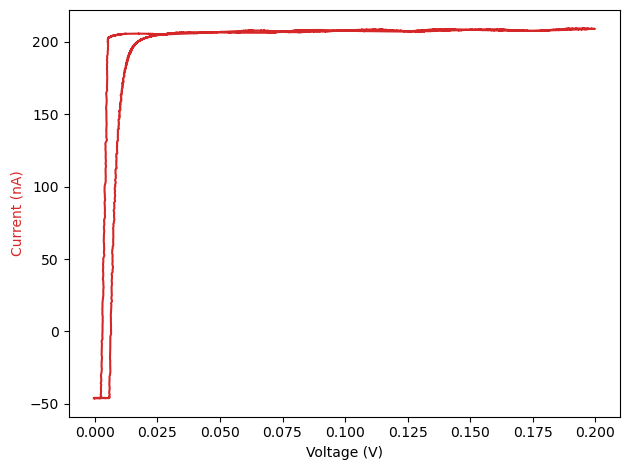

33136.331477687505 nS
W2
Thresh Current:200nA bias:4.0V


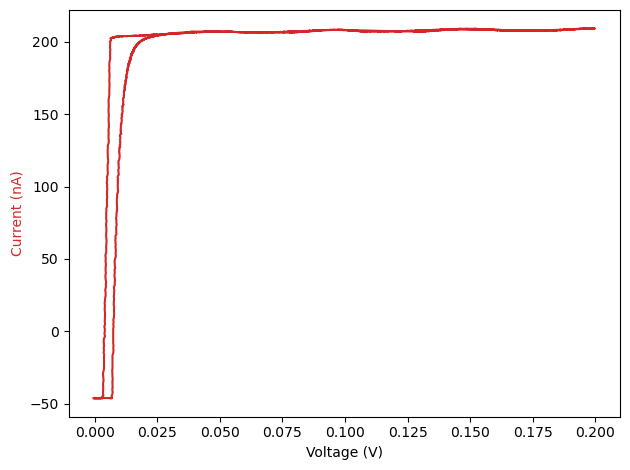

36386.58649287226 nS
W3
Thresh Current:200nA bias:4.0V


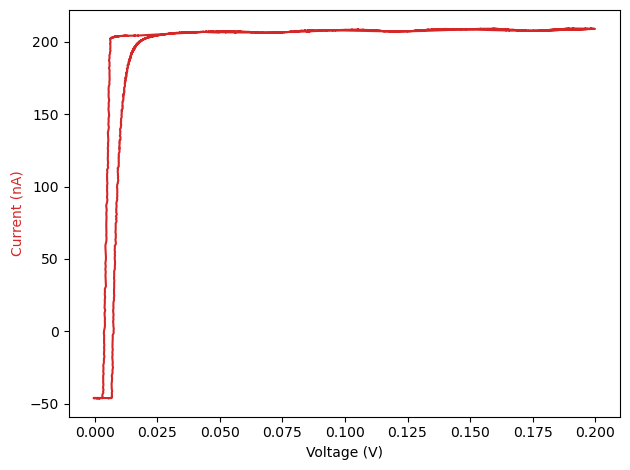

36074.884176049614 nS
W4
Thresh Current:200nA bias:4.0V


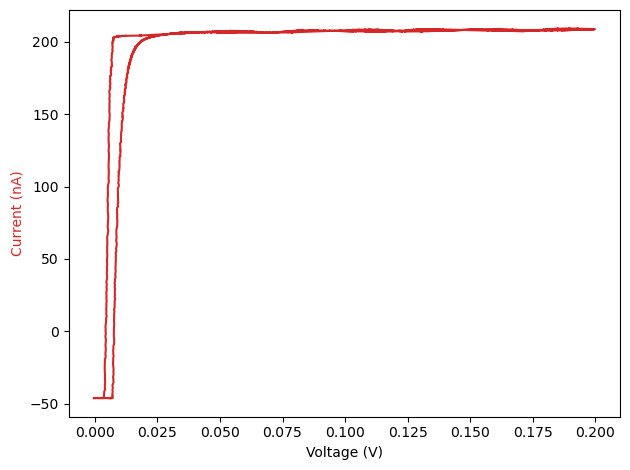

36693.995052206155 nS
W5
Thresh Current:200nA bias:4.0V


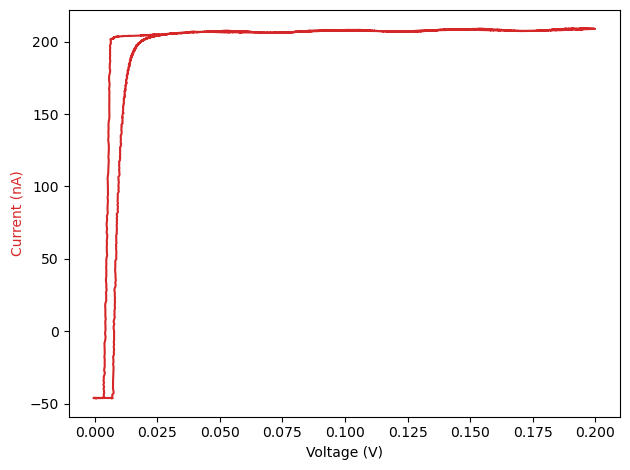

36680.1256508834 nS
W6
Thresh Current:200nA bias:4.0V


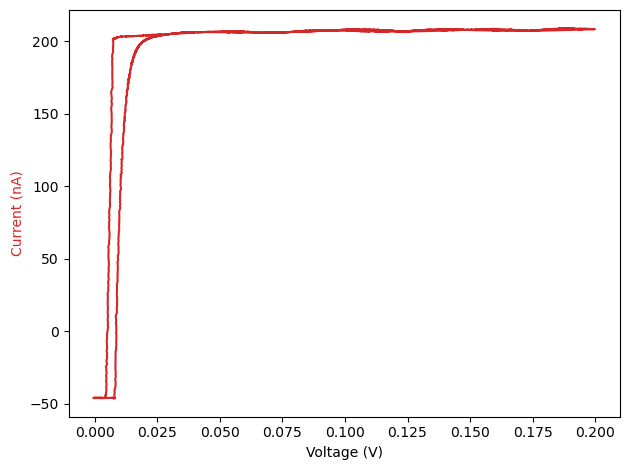

36719.2447143021 nS
W7
Thresh Current:200nA bias:4.0V


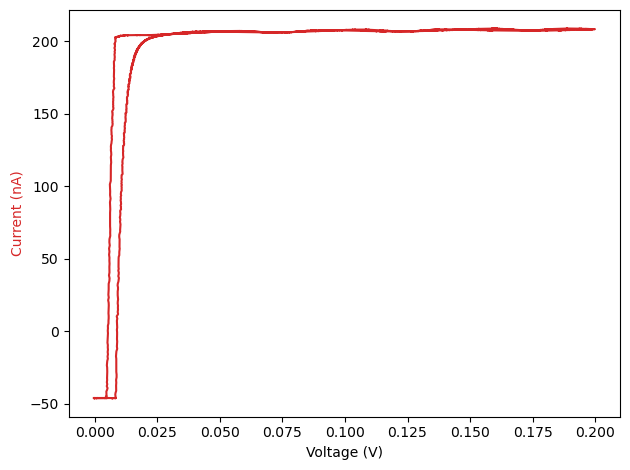

36759.53589489281 nS
W8
Thresh Current:200nA bias:4.0V


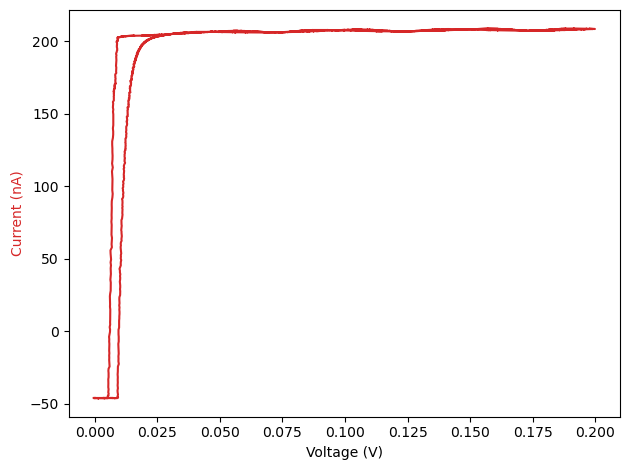

36365.277100624604 nS
N1
Thresh Current:200nA bias:4.0V


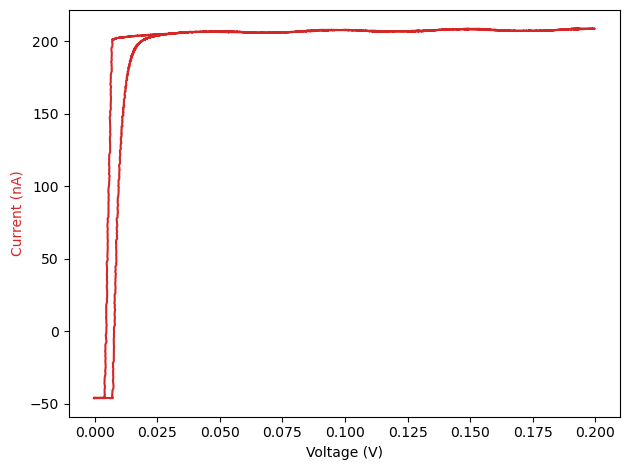

36481.52865865411 nS
N2
Thresh Current:200nA bias:4.0V


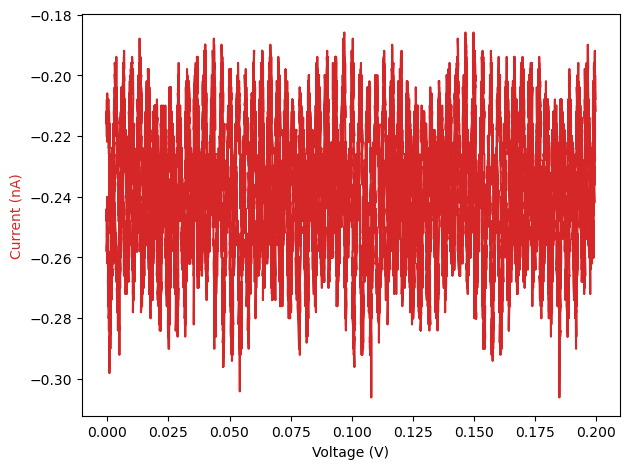

-0.06956130414629445 nS
N3
Thresh Current:200nA bias:4.0V


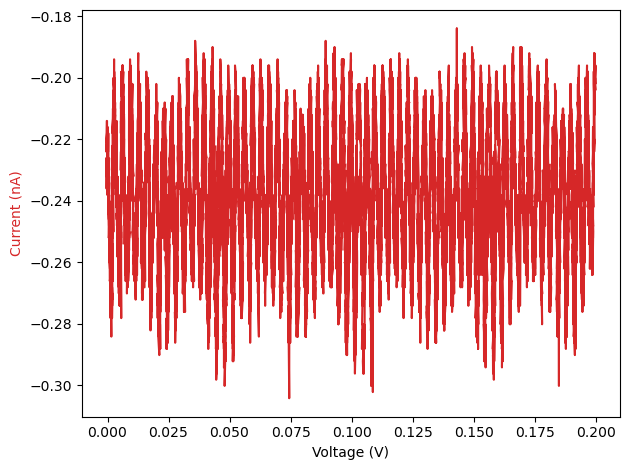

-0.06718157612571082 nS
N4
Thresh Current:200nA bias:4.0V


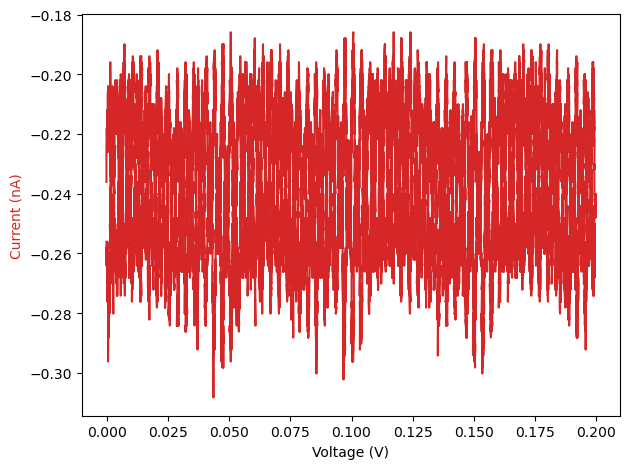

-0.11178280179582363 nS
N5
Thresh Current:200nA bias:4.0V


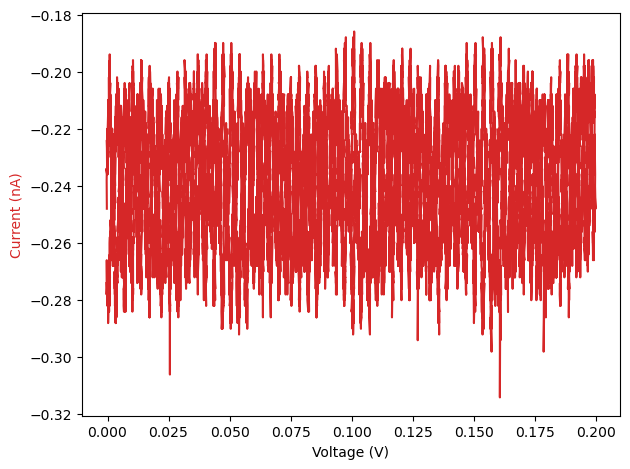

-0.08465601778753802 nS
N6
Thresh Current:200nA bias:4.0V


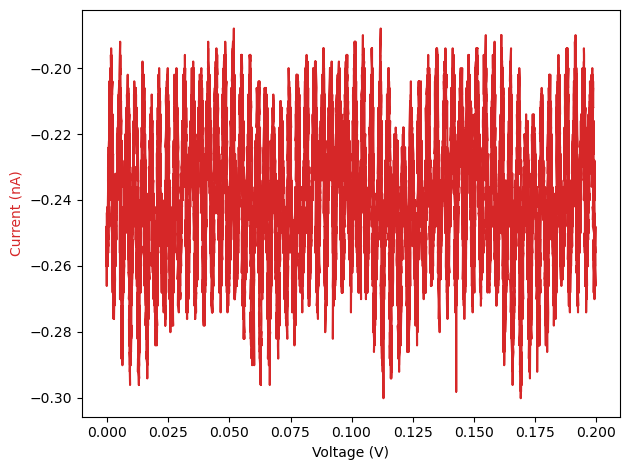

0.012554535294173759 nS
N7
Thresh Current:200nA bias:4.0V


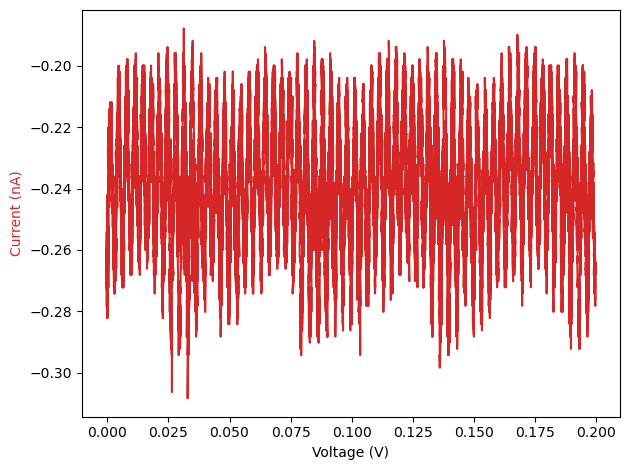

0.038601839690173154 nS
N8
Thresh Current:200nA bias:4.0V


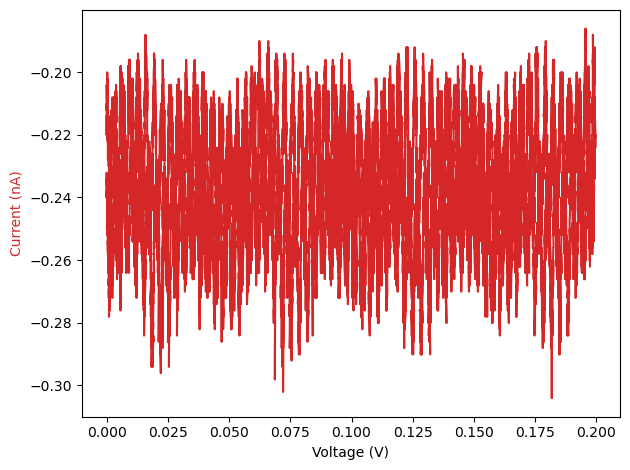

0.10762903126682935 nS
E1
Thresh Current:200nA bias:4.0V


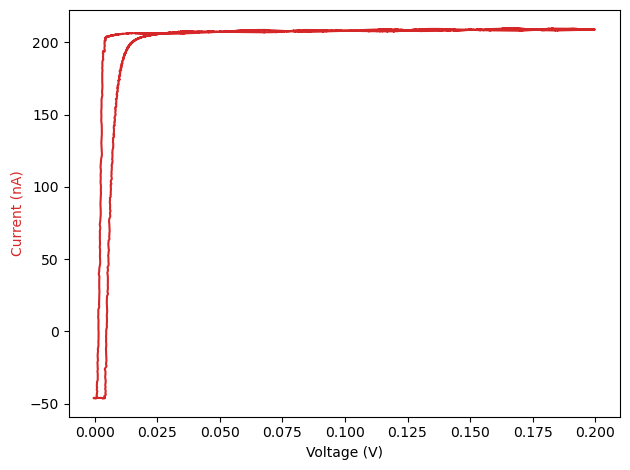

28555.502011008917 nS
E2
Thresh Current:200nA bias:4.0V


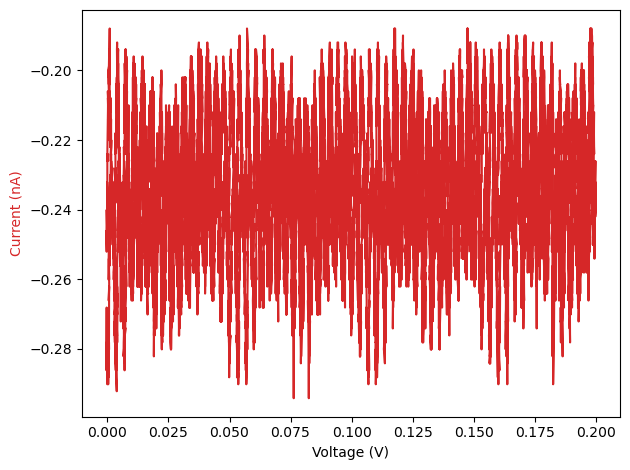

-0.05598851866361662 nS
E3
Thresh Current:200nA bias:4.0V


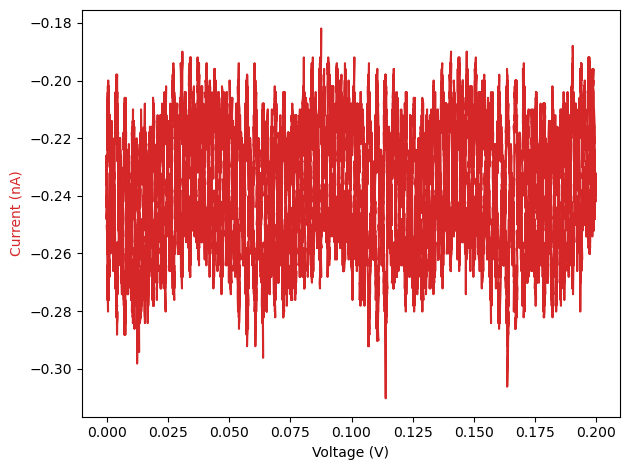

-0.024619105397251585 nS
E4
Thresh Current:200nA bias:4.0V


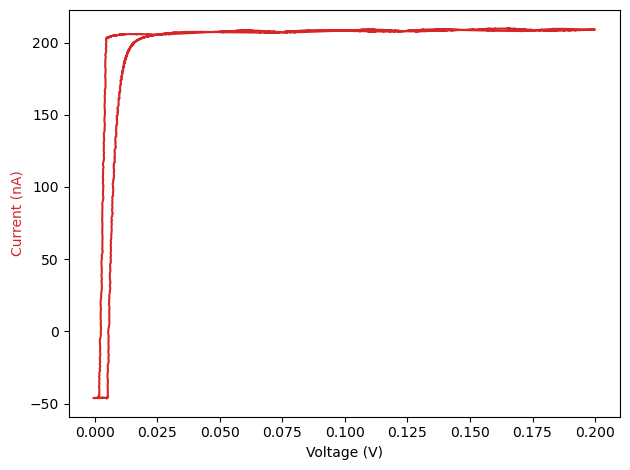

31588.10826275397 nS
E5
Thresh Current:200nA bias:4.0V


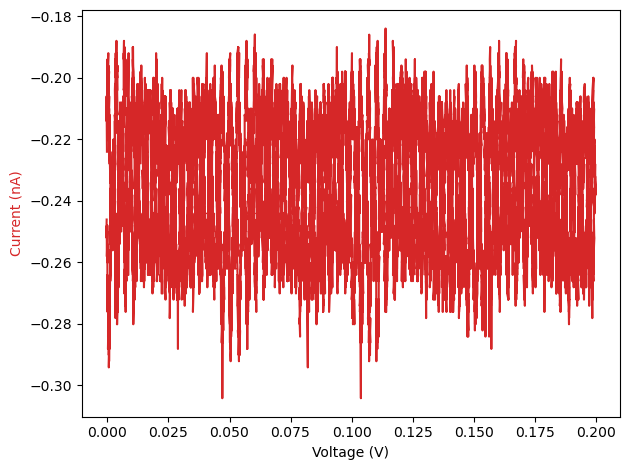

-0.12663909882472635 nS
E6
Thresh Current:200nA bias:4.0V


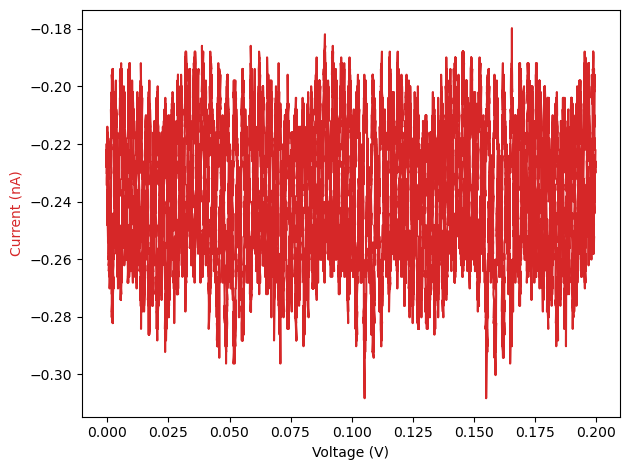

-0.025700812003959315 nS
E7
Thresh Current:200nA bias:4.0V


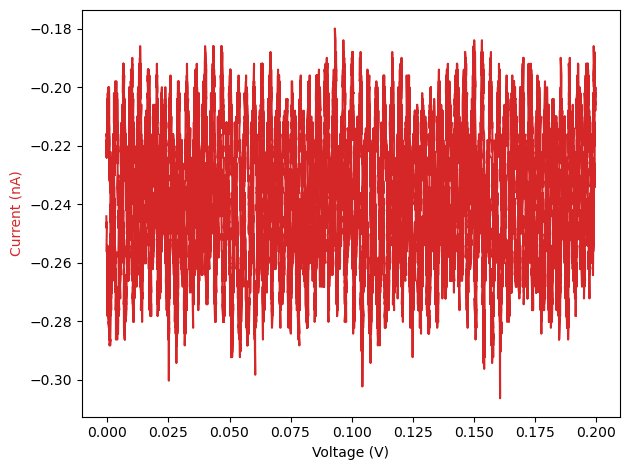

-0.06402805930200187 nS
E8
Thresh Current:200nA bias:4.0V


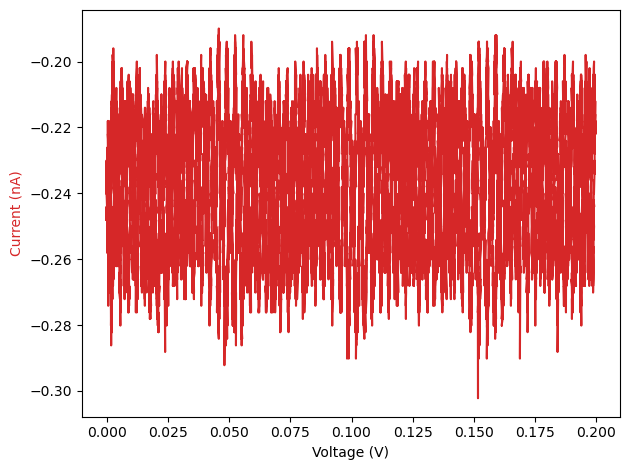

-0.053696592894482115 nS
S1
Thresh Current:200nA bias:4.0V


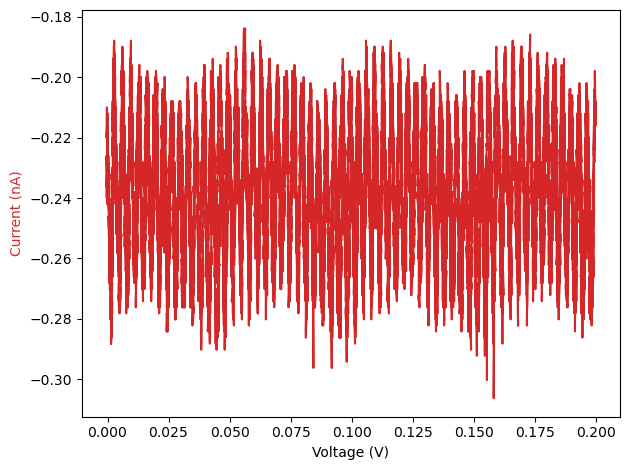

-0.07529791759418016 nS
S2
Thresh Current:200nA bias:4.0V


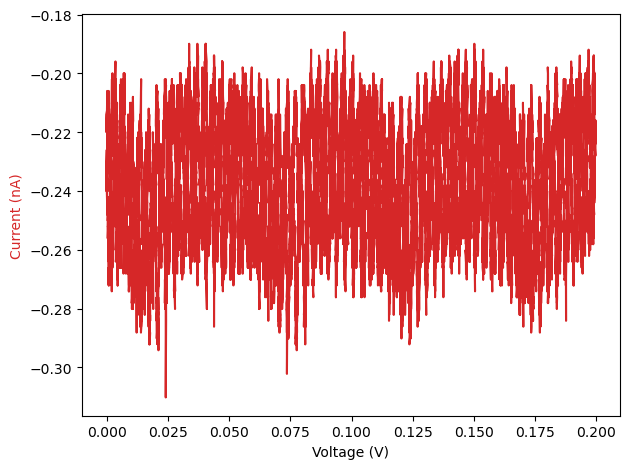

0.028092319024044635 nS
S3
Thresh Current:200nA bias:4.0V


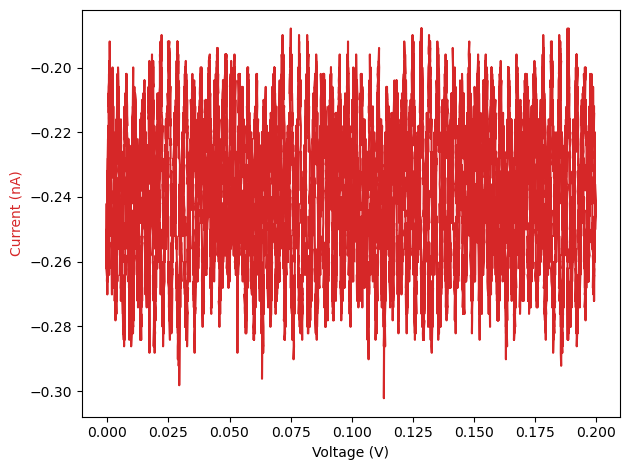

0.1010133783205296 nS
S4
Thresh Current:200nA bias:4.0V


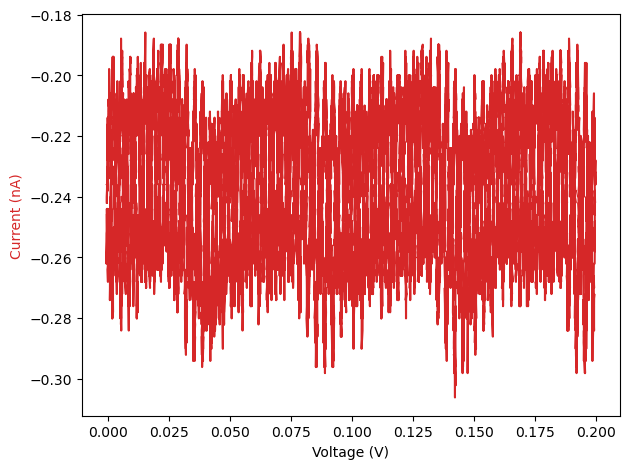

0.07841490867398895 nS
S5
Thresh Current:200nA bias:4.0V


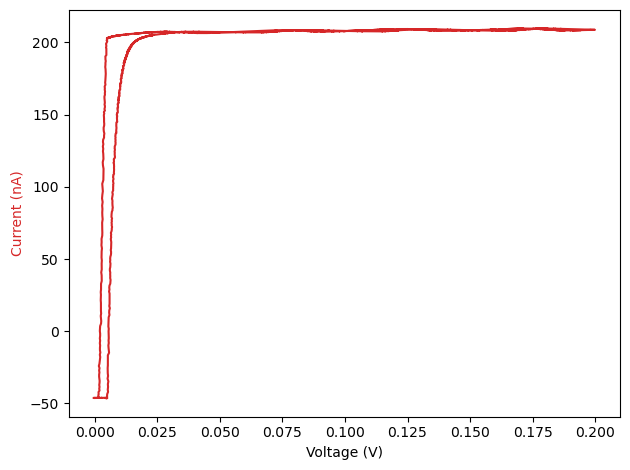

31447.155280118444 nS
S6
Thresh Current:200nA bias:4.0V


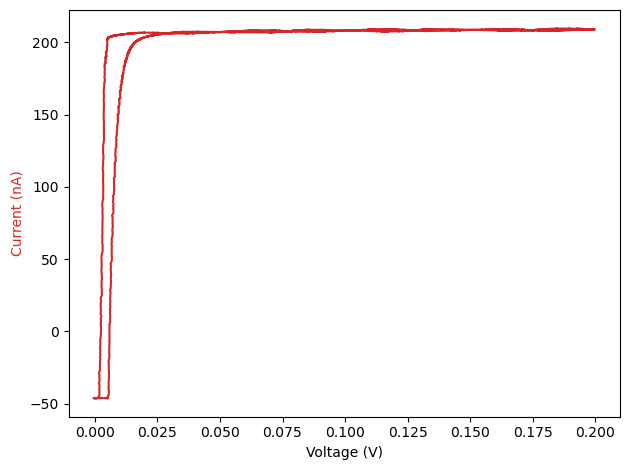

32871.91920116489 nS
S7
Thresh Current:200nA bias:4.0V


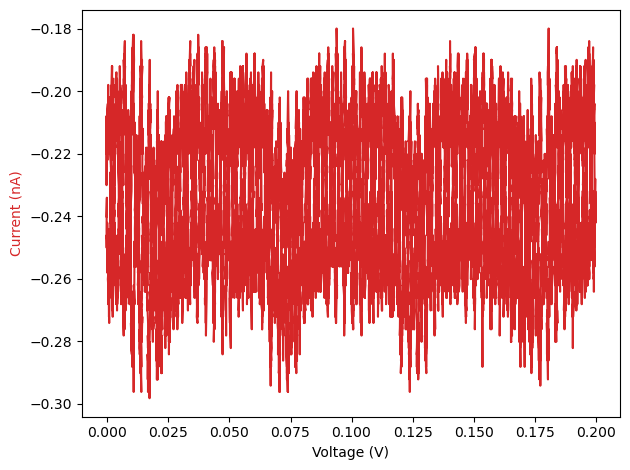

-0.010027186879281478 nS
S8
Thresh Current:200nA bias:4.0V


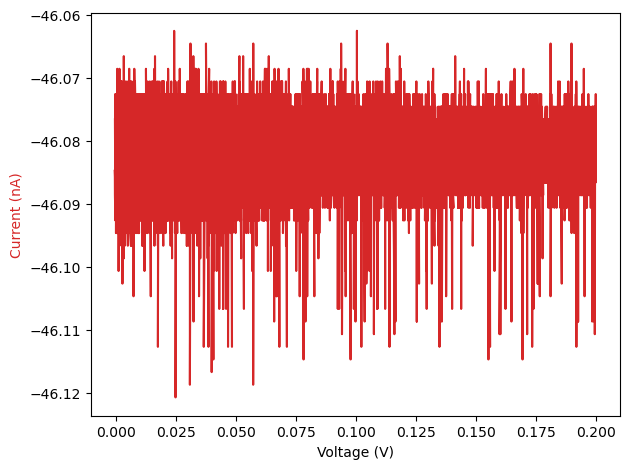

0.023507132509558853 nS


In [6]:
for channel in  plater.channels:
    plater.setBias(0)
    plater.SelectChannel(channel)
    if channel not in currentholder:
        currentholder[channel]={}
    print(channel)
    time.sleep(1)
    plater.TopElectrode()


    plater.setThreshold(current_nA = 200)
    plater.ResetDevice()
    plater.disableThreshold()
    plater.setBias(0)    

   

    conductance_nA, outBias,currents =plater.runIV2( maxVoltage_mV=200, slew_mV_s=200, plot=True)


    with open(f'C:/Data/Plater/{wafer}/{chip}/{channel}_BeforeIV2.np', 'wb') as fp:
        np.save(fp,outBias)
        np.save(fp,currents)
        np.save(fp,conductance_nA)
    
    if "tops" not in currentholder[channel]:
        currentholder[channel]["tops"]={}
  
    currentholder[channel]["tops"]['IVParams']={"conductance_nA":conductance_nA, "outBias":outBias,"currents":currents}
    
    if np.max(currents)<150:
        unshortedChannels.append(channel)

W1
Thresh Current:200nA bias:4.0V


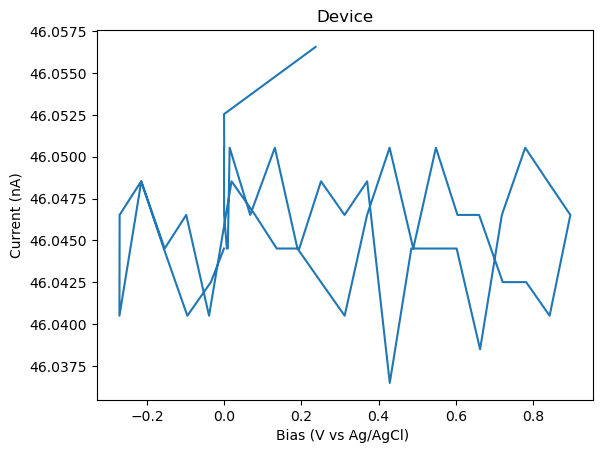

In [6]:
for channel in  unshortedChannels:
    plater.setBias(0)
    plater.SelectChannel(channel)
    if channel not in currentholder:
        currentholder[channel]={}
    print(channel)
    time.sleep(1)
    plater.TopElectrode()


    plater.setThreshold(current_nA = 200)
    plater.ResetDevice()
    plater.disableThreshold()
    plater.setBias(0)    

   


    Vs,Cs,DeviceCs= plater.runCV_autolab(
        startPotential_mV=0, 
        upperPotenial_mV=900, 
        lowerPotential_mV=-300,
        stopPotential_mV=0,
        cycles=2,
        scanrate_mV_s=200, 
        plot=True)
    break

    with open(f'C:/Data/Plater/{wafer}/{chip}/{channel}_BeforeCV_Top.np', 'wb') as fp:
        np.save(fp,Vs)
        np.save(fp,DeviceCs)

    if "tops" not in currentholder[channel]:
        currentholder[channel]["tops"]={}

    currentholder[channel]["tops"]['CVParams'] ={"Vs":Vs, "DeviceCs":DeviceCs}

    #biasi, currents, rpotentials, pcurrents=plater.runStrip_autolab(startVoltage_V=0,maxVoltage_V=-1.2,slew_mV_s=200,plot=True)
    plater.BottomElectrode()
    plater.setThreshold(current_nA = 200)
    plater.ResetDevice()
    plater.disableThreshold()
    plater.setBias(0)   
    
    bottoms={}
    Vs,Cs,DeviceCs= plater.runCV_autolab(
        startPotential_mV=0, 
        upperPotenial_mV=900, 
        lowerPotential_mV=-300,
        stopPotential_mV=0,
        cycles=2,
        scanrate_mV_s=200, 
        plot=True)

    if "bottoms" not in currentholder[channel]:
        currentholder[channel]["bottoms"]={}
        
    with open(f'C:/Data/Plater/{wafer}/{chip}/{channel}_BeforeCVBottom.np', 'wb') as fp:
        np.save(fp,Vs)
        np.save(fp,DeviceCs)
        
    currentholder[channel]["bottoms"]['CVParams'] ={"Vs":Vs, "DeviceCs":DeviceCs}
 

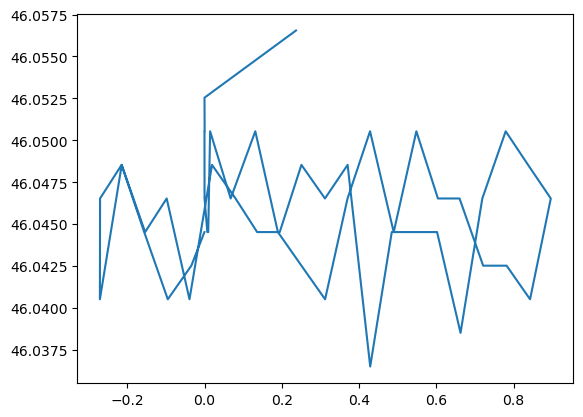

In [8]:
plt.plot(Vs,DeviceCs)

N2
Thresh Current:200nA bias:4.0V


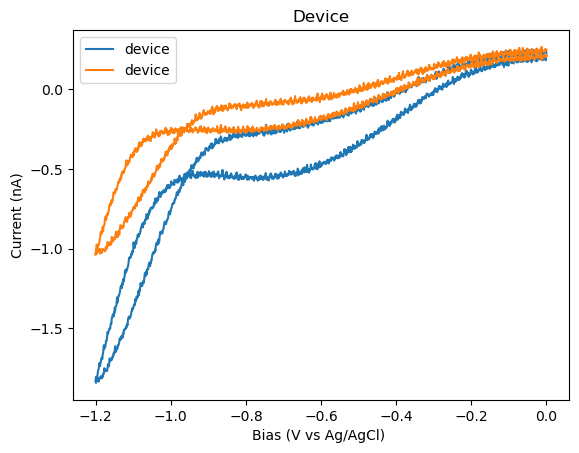

N3
Thresh Current:200nA bias:4.0V


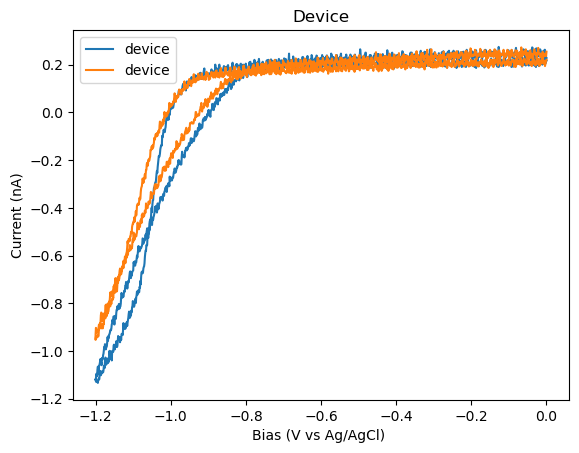

N4
Thresh Current:200nA bias:4.0V


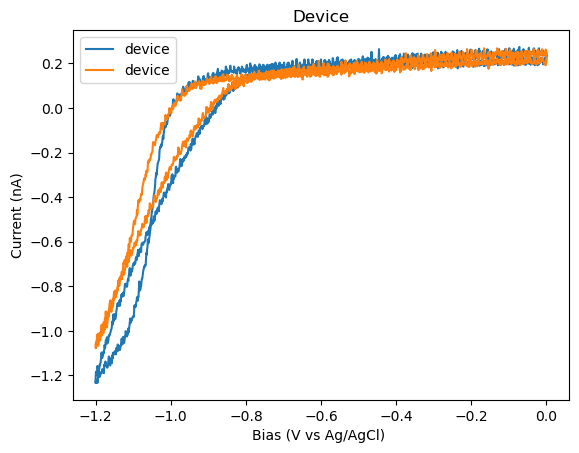

N5
Thresh Current:200nA bias:4.0V


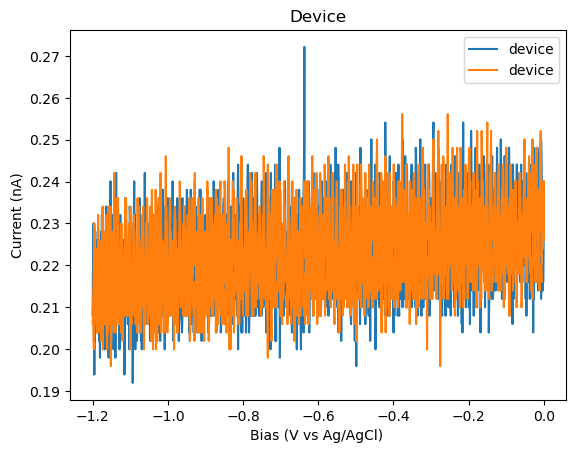

N6
Thresh Current:200nA bias:4.0V


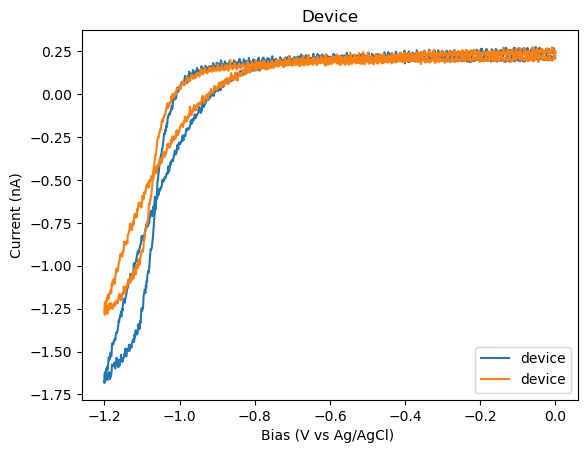

N7
Thresh Current:200nA bias:4.0V


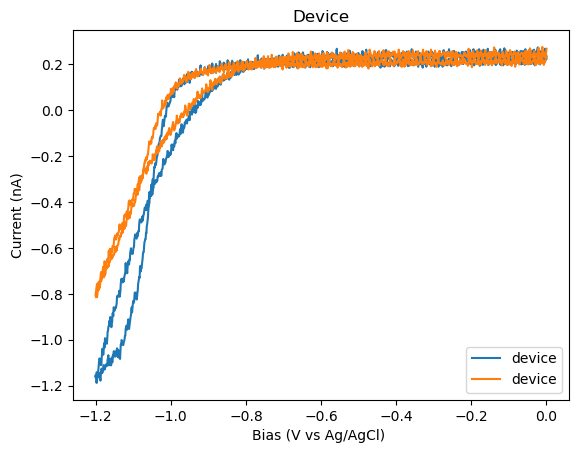

N8
Thresh Current:200nA bias:4.0V


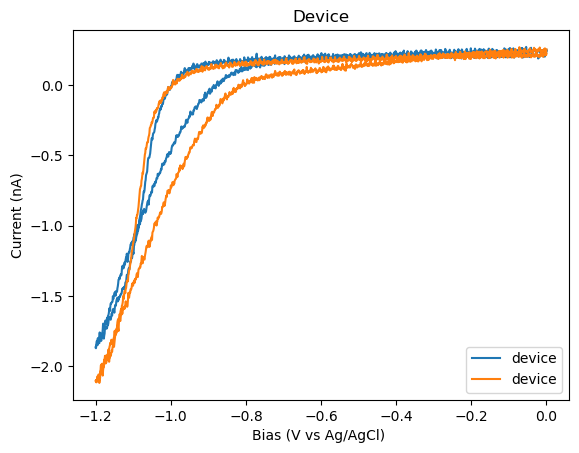

E2
Thresh Current:200nA bias:4.0V


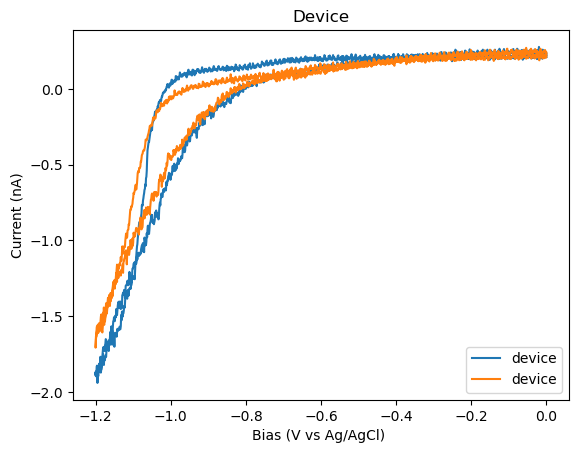

E3
Thresh Current:200nA bias:4.0V


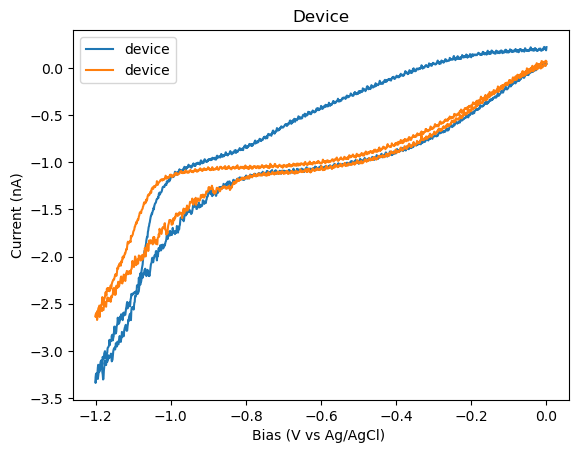

E5
Thresh Current:200nA bias:4.0V


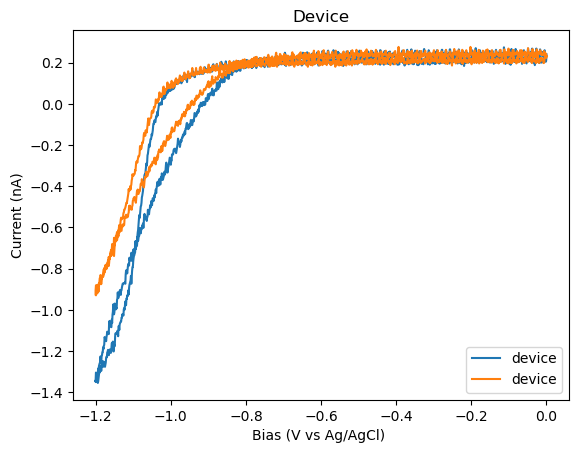

E6
Thresh Current:200nA bias:4.0V


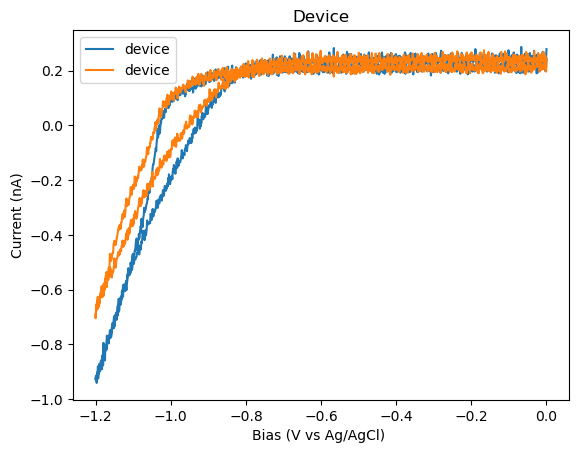

E7
Thresh Current:200nA bias:4.0V


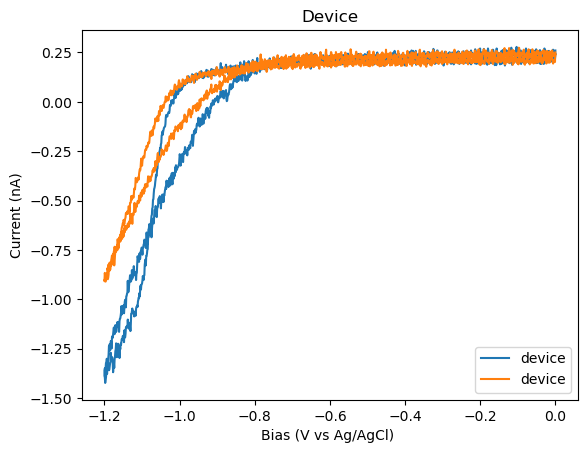

E8
Thresh Current:200nA bias:4.0V


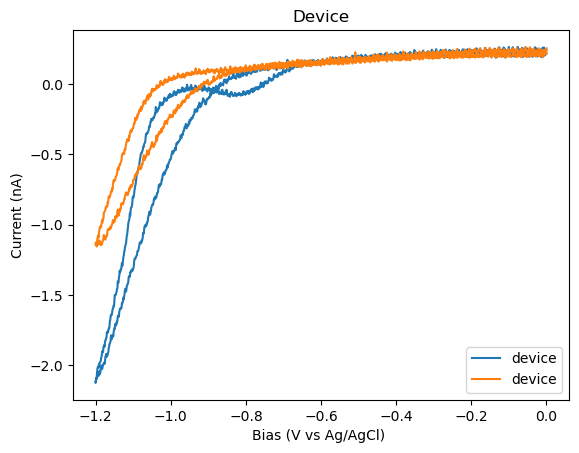

S1
Thresh Current:200nA bias:4.0V


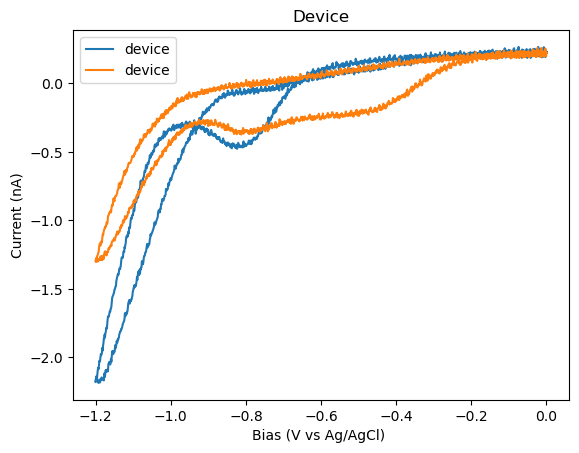

S2
Thresh Current:200nA bias:4.0V


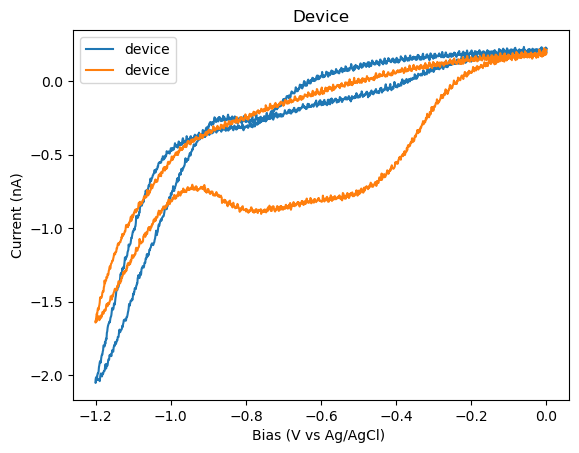

S3
Thresh Current:200nA bias:4.0V


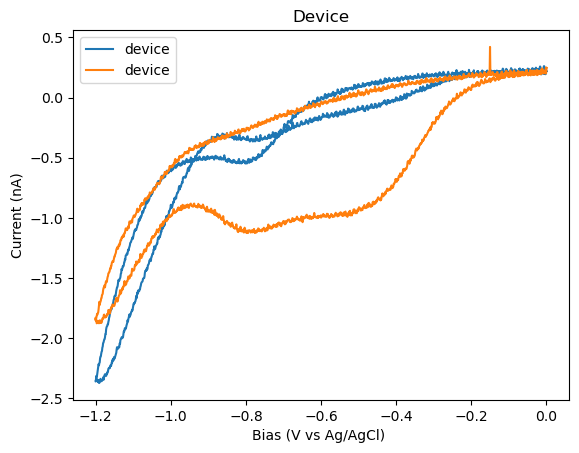

S4
Thresh Current:200nA bias:4.0V


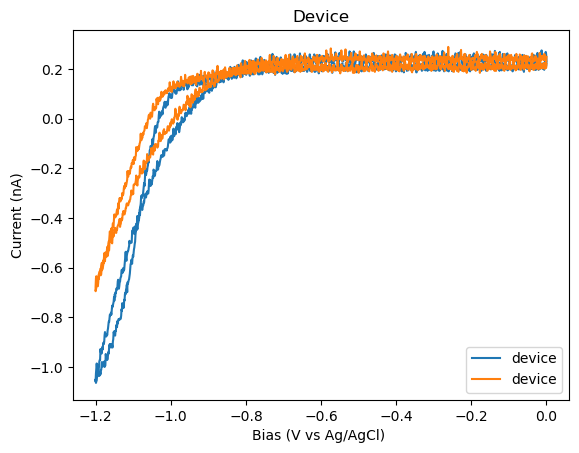

S7
Thresh Current:200nA bias:4.0V


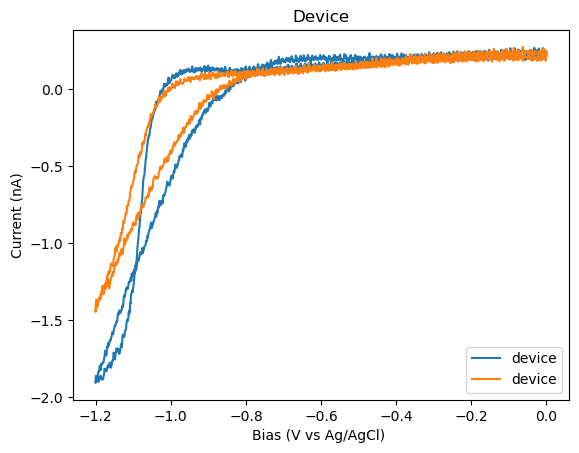

S8
Thresh Current:200nA bias:4.0V


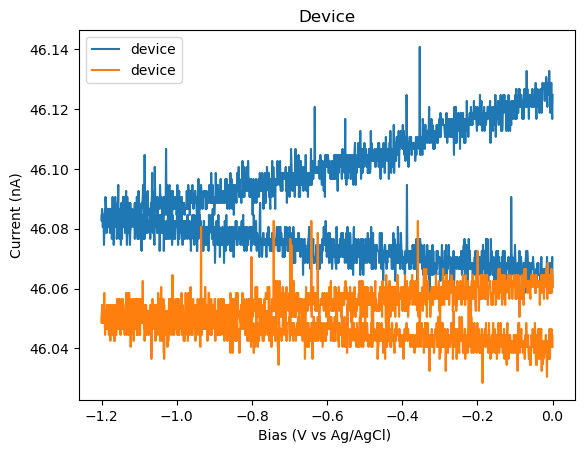

In [7]:
for channel in  unshortedChannels:
    plater.setBias(0)
    plater.SelectChannel(channel)
    if channel not in currentholder:
        currentholder[channel]={}
    print(channel)
    time.sleep(1)
    plater.TopElectrode()


    plater.setThreshold(current_nA = 200)
    plater.ResetDevice()
    plater.disableThreshold()
    plater.setBias(0)    

    if "strip" not in currentholder[channel]:
        currentholder[channel]["strip"]={}
        
    
    slew_mV_s=200
    second=True
    biasi, currents, rpotentials, pcurrents=plater.runStrip_autolab(startVoltage_V=0,maxVoltage_V=-1.2,slew_mV_s=slew_mV_s,plot=True)
    if second:
        biasi2, currents2, rpotentials2, pcurrents2=plater.runStrip_autolab(startVoltage_V=0,maxVoltage_V=-1.2,slew_mV_s=slew_mV_s,plot=True)
    
    plt.show()
    
    with open(f'C:/Data/Plater/{wafer}/{chip}/{channel}_strip_top.np', 'wb') as fp:
        np.save(fp,biasi)
        np.save(fp,currents)
        np.save(fp,rpotentials)
        np.save(fp,pcurrents)
        if second:
            np.save(fp,biasi2)
            np.save(fp,currents2)
            np.save(fp,rpotentials2)
            np.save(fp,pcurrents2)
        
        np.save(fp,slew_mV_s)
        

    
    currentholder[channel]["strip"] ={'biasi':biasi,'currents': currents,'rpotentials': rpotentials,'pcurrents': pcurrents}
     

N2
Thresh Current:200nA bias:4.0V


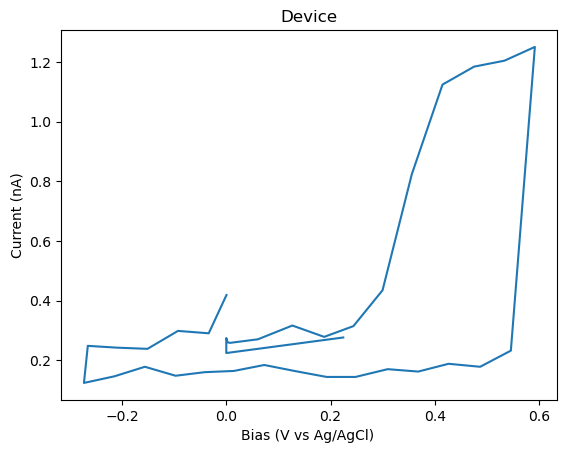

Thresh Current:200nA bias:4.0V


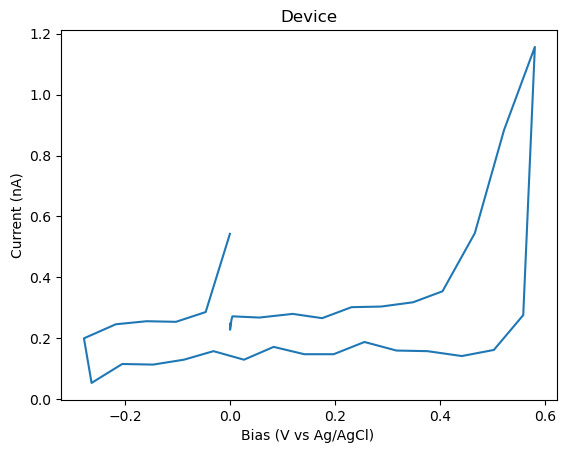

N3
Thresh Current:200nA bias:4.0V


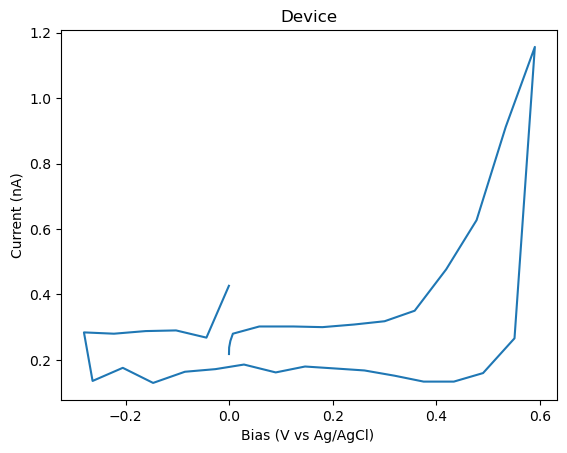

Thresh Current:200nA bias:4.0V


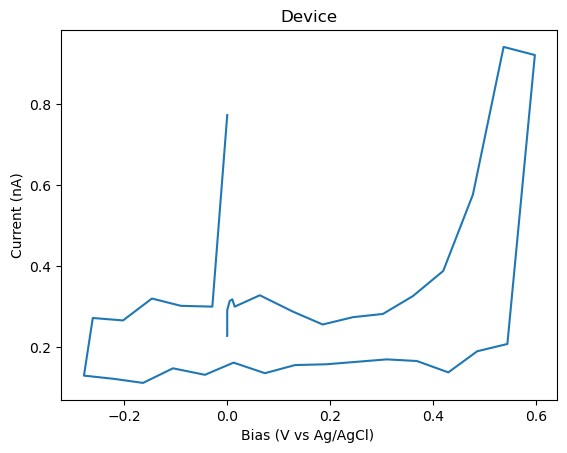

N4
Thresh Current:200nA bias:4.0V


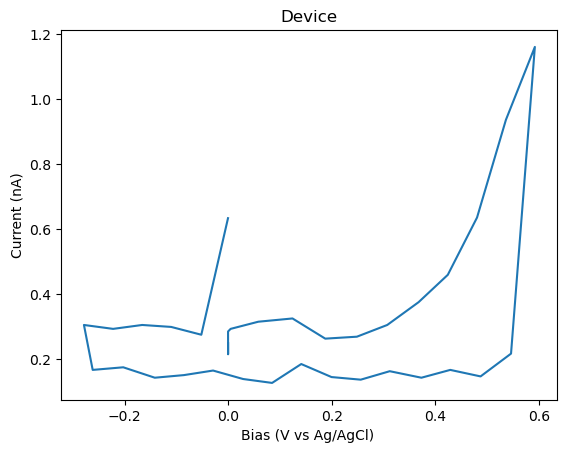

Thresh Current:200nA bias:4.0V


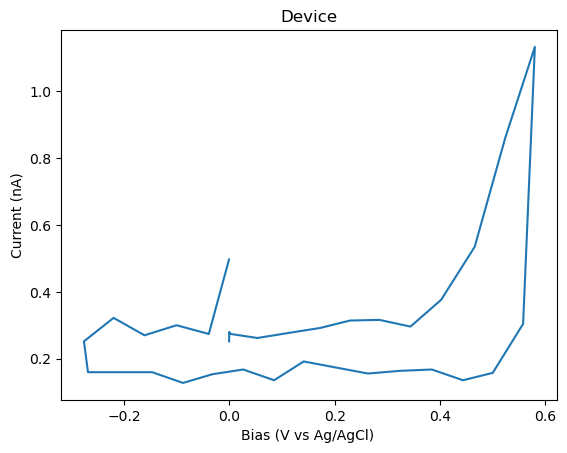

N5
Thresh Current:200nA bias:4.0V


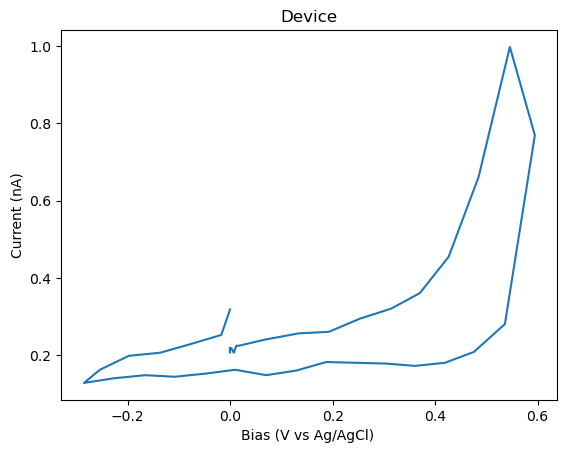

Thresh Current:200nA bias:4.0V


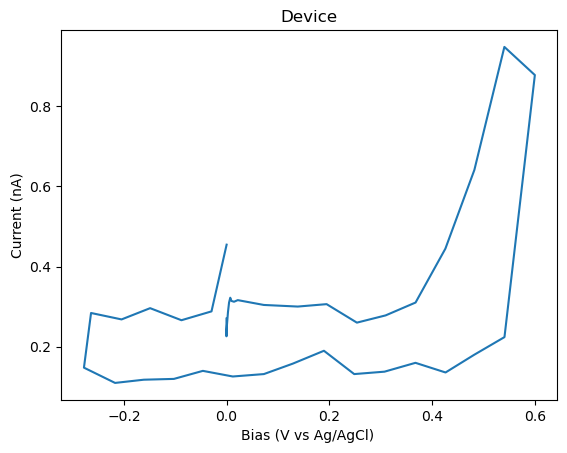

N6
Thresh Current:200nA bias:4.0V


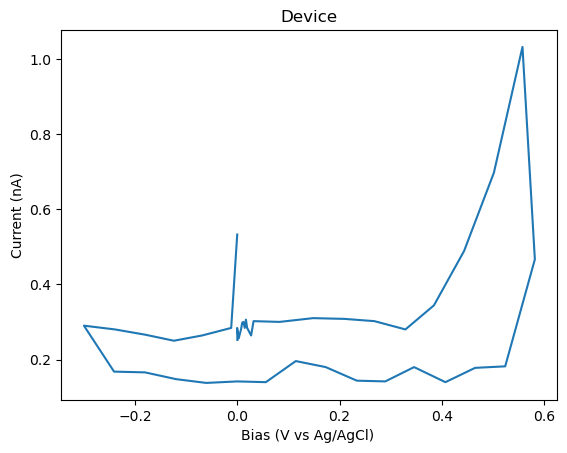

Thresh Current:200nA bias:4.0V


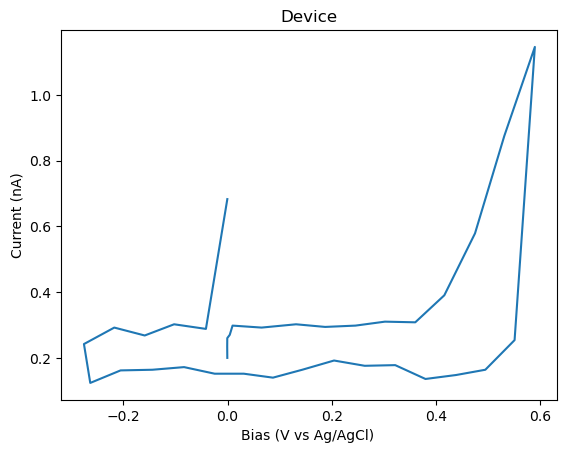

N7
Thresh Current:200nA bias:4.0V


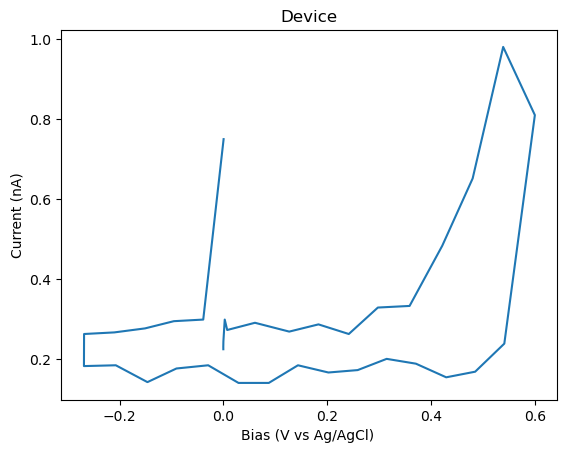

Thresh Current:200nA bias:4.0V


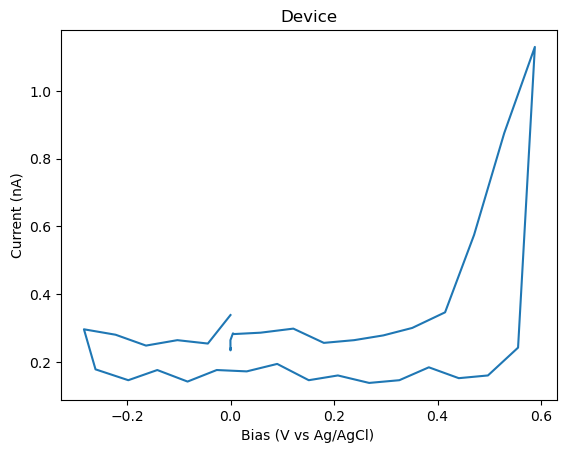

N8
Thresh Current:200nA bias:4.0V


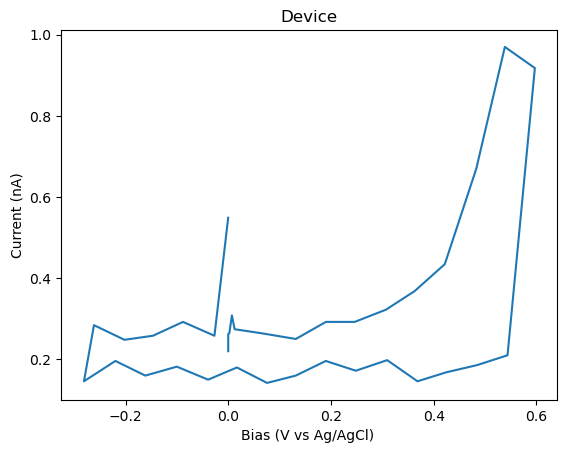

Thresh Current:200nA bias:4.0V


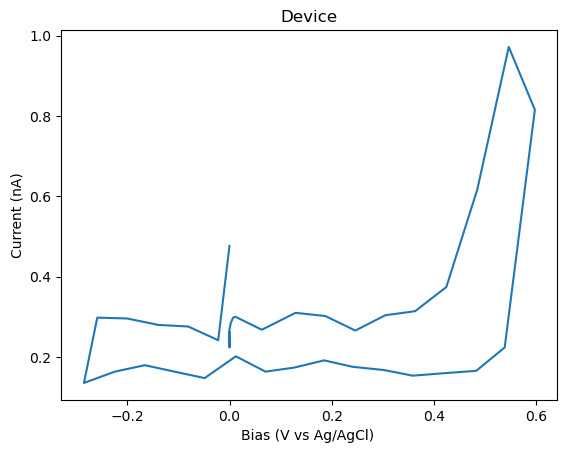

E2
Thresh Current:200nA bias:4.0V


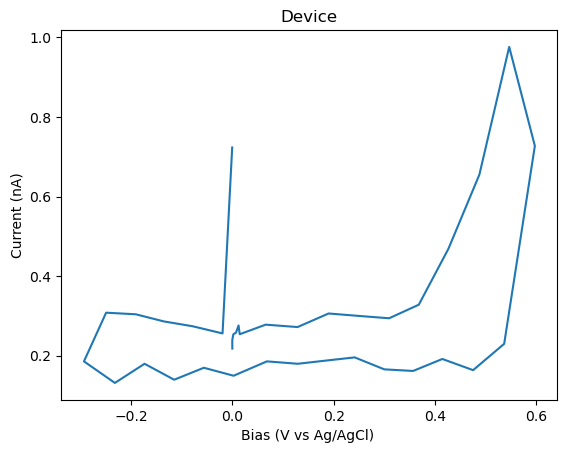

Thresh Current:200nA bias:4.0V


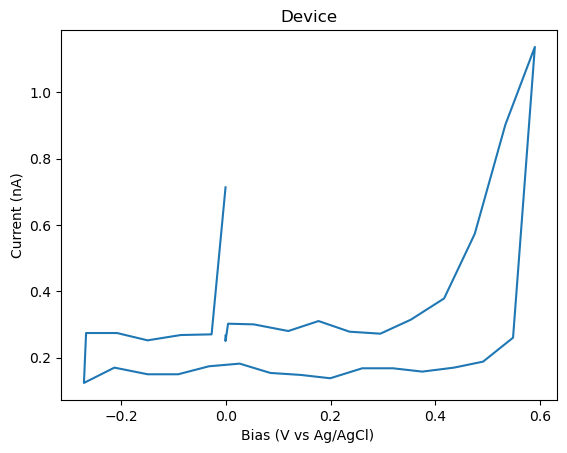

E3
Thresh Current:200nA bias:4.0V


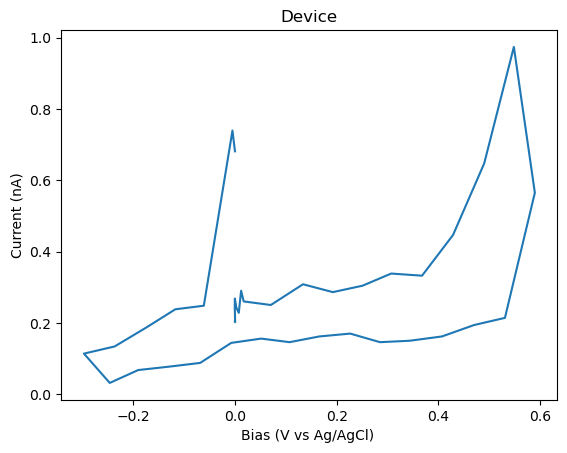

Thresh Current:200nA bias:4.0V


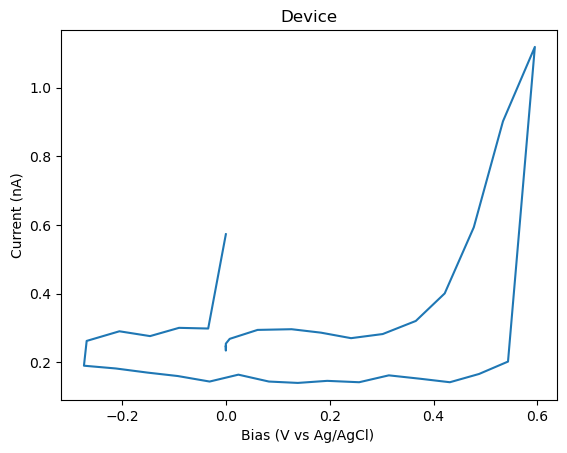

E5
Thresh Current:200nA bias:4.0V


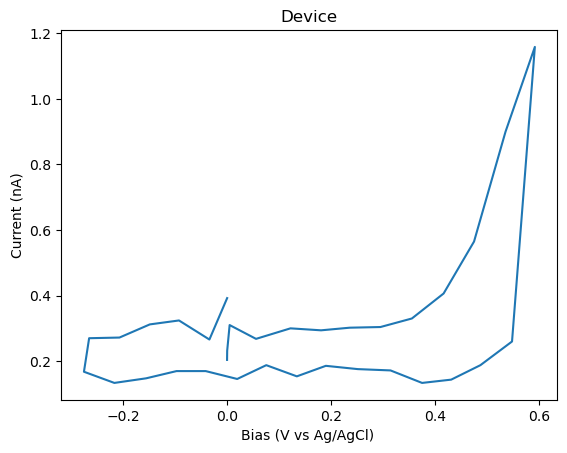

Thresh Current:200nA bias:4.0V


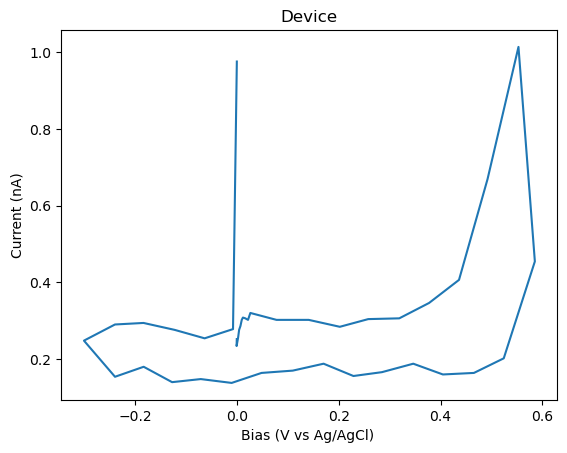

E6
Thresh Current:200nA bias:4.0V


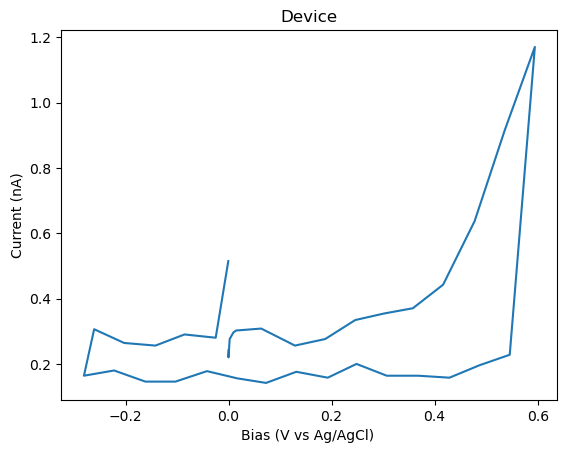

Thresh Current:200nA bias:4.0V


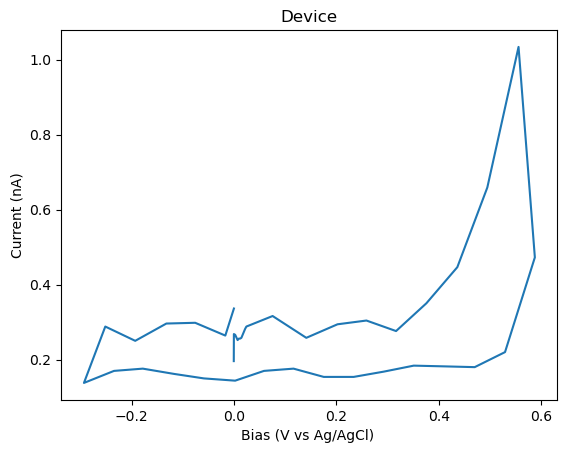

E7
Thresh Current:200nA bias:4.0V


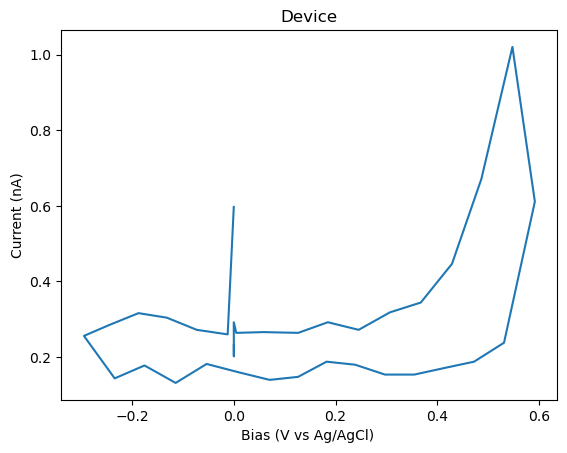

Thresh Current:200nA bias:4.0V


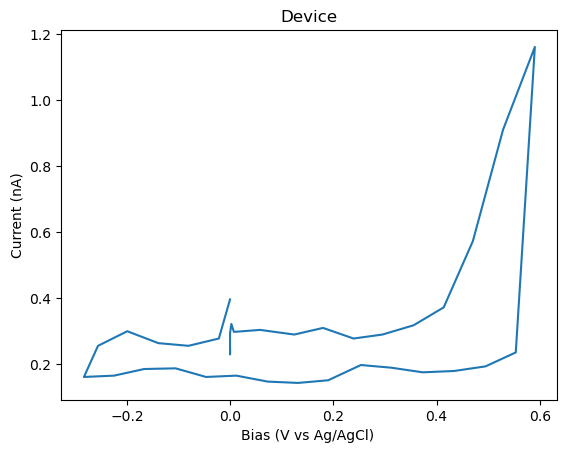

E8
Thresh Current:200nA bias:4.0V


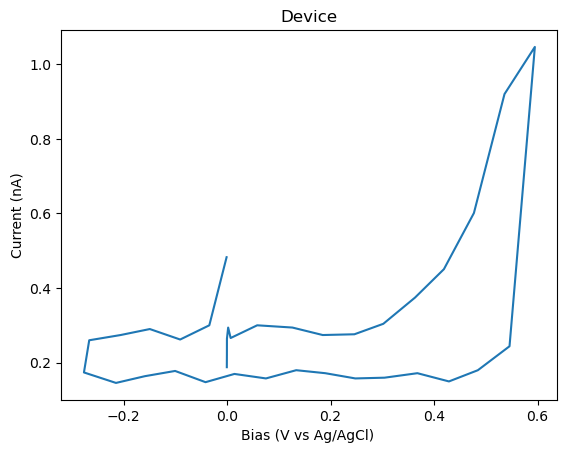

Thresh Current:200nA bias:4.0V


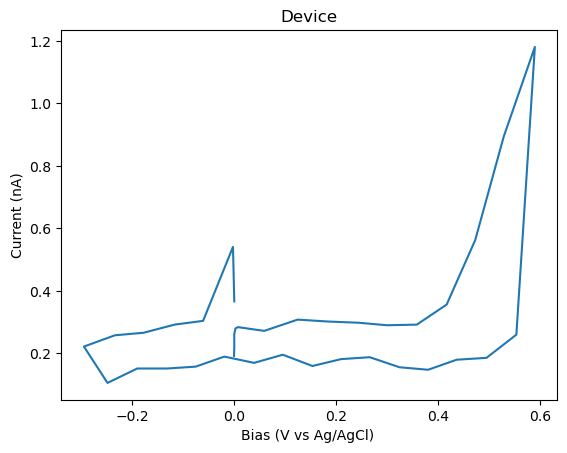

S1
Thresh Current:200nA bias:4.0V


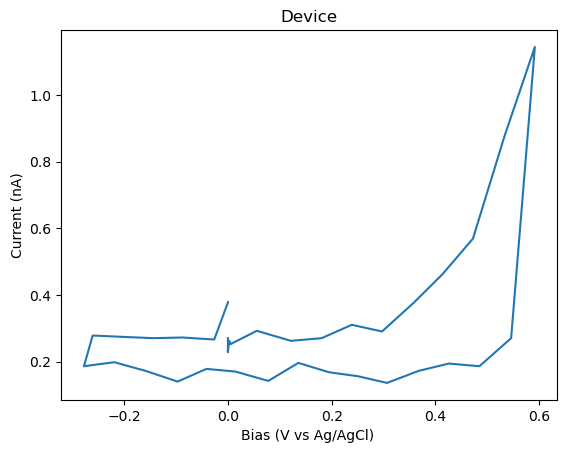

Thresh Current:200nA bias:4.0V


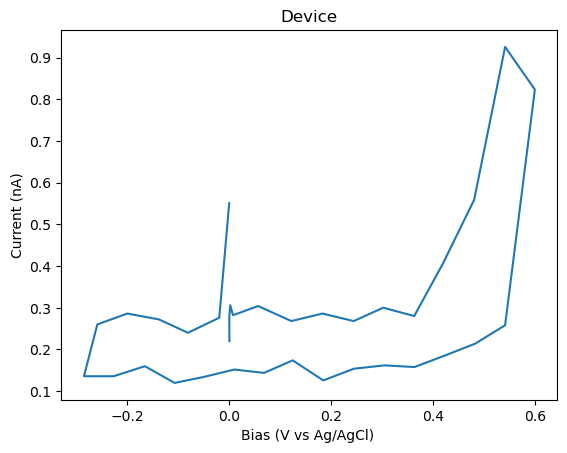

S2
Thresh Current:200nA bias:4.0V


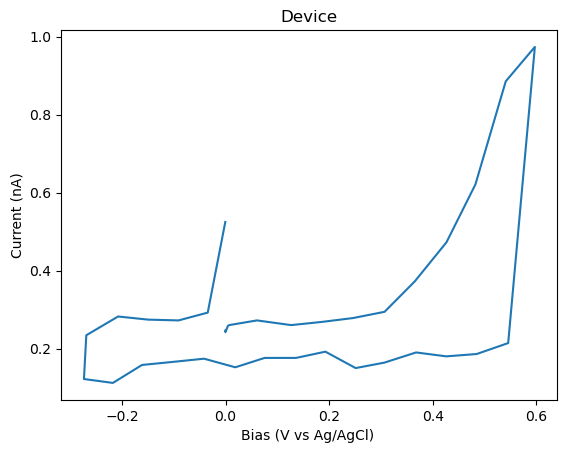

Thresh Current:200nA bias:4.0V


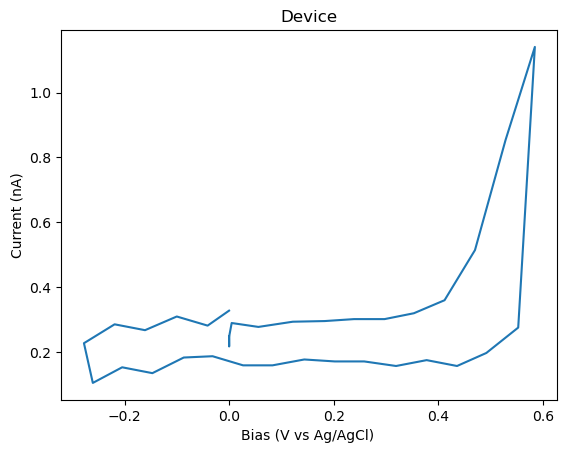

S3
Thresh Current:200nA bias:4.0V


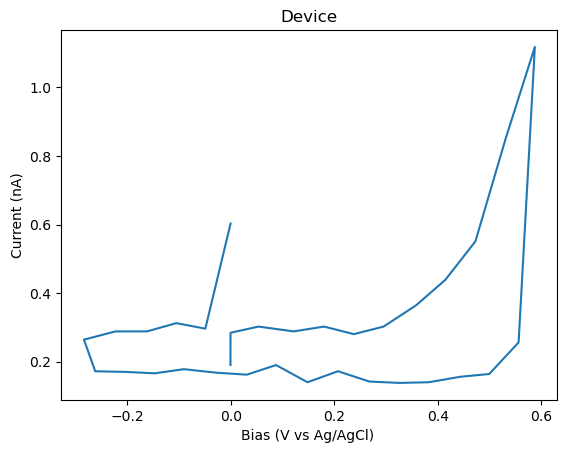

Thresh Current:200nA bias:4.0V


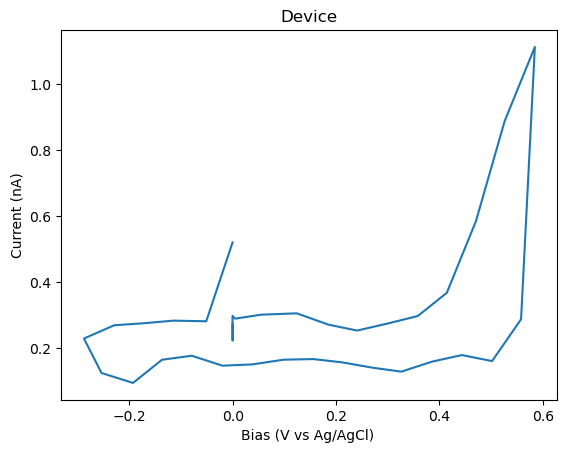

S4
Thresh Current:200nA bias:4.0V


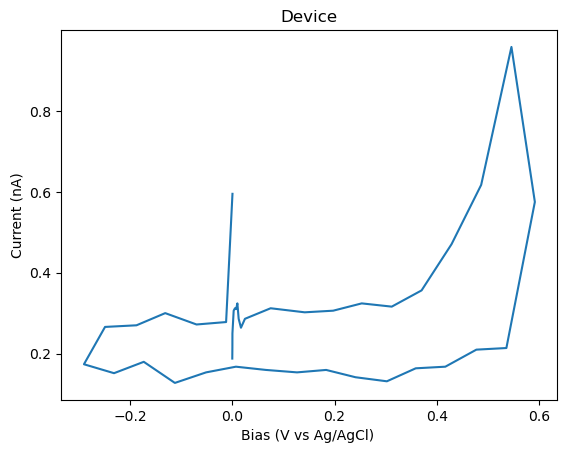

Thresh Current:200nA bias:4.0V


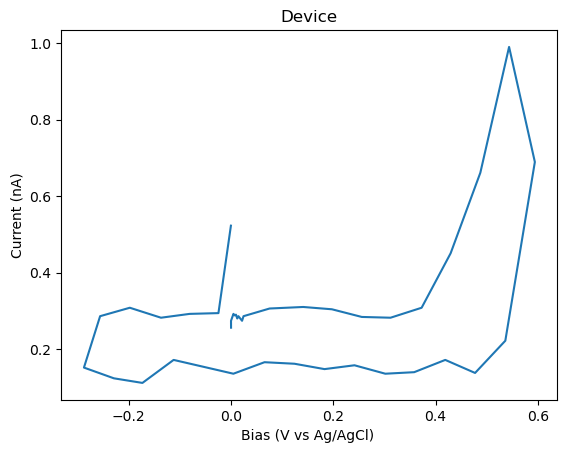

S7
Thresh Current:200nA bias:4.0V


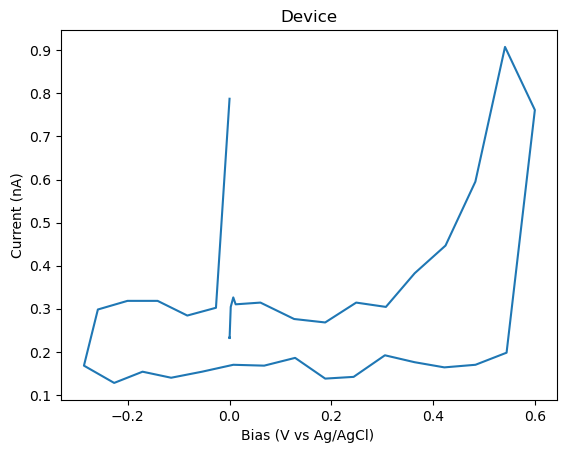

Thresh Current:200nA bias:4.0V


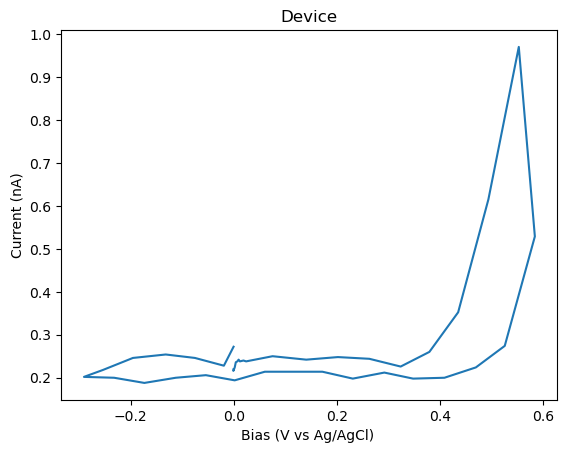

S8
Thresh Current:200nA bias:4.0V


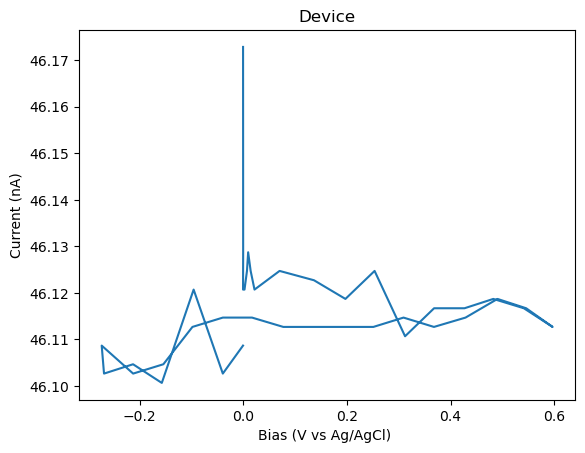

Thresh Current:200nA bias:4.0V


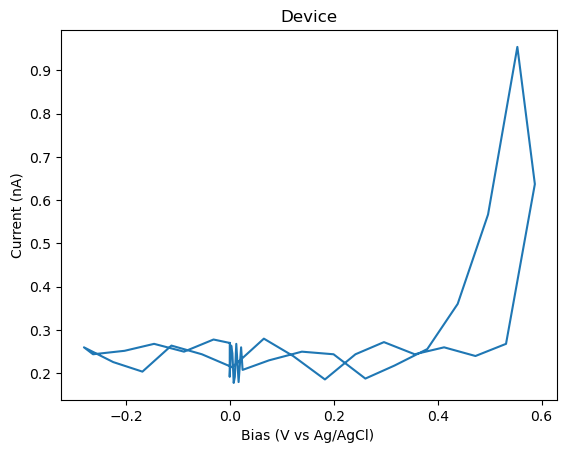

In [7]:
for channel in  unshortedChannels:
    plater.setBias(0)
    plater.SelectChannel(channel)
    if channel not in currentholder:
        currentholder[channel]={}
    print(channel)
    time.sleep(1)
    plater.TopElectrode()


    plater.setThreshold(current_nA = 200)
    plater.ResetDevice()
    plater.disableThreshold()
    plater.setBias(0)    

   


    Vs,Cs,DeviceCs= plater.runCV_autolab(
        startPotential_mV=0, 
        upperPotenial_mV=600, 
        lowerPotential_mV=-300,
        stopPotential_mV=0,
        cycles=2,
        scanrate_mV_s=200, 
        plot=True)
    
    if "tops2" not in currentholder[channel]:
        currentholder[channel]["tops2"]={}

    currentholder[channel]["tops2"]['CVParams'] ={"Vs":Vs, "DeviceCs":DeviceCs}
    
    with open(f'C:/Data/Plater/{wafer}/{chip}/{channel}_AfterStrip_CV_Top.np', 'wb') as fp:
        np.save(fp,Vs)
        np.save(fp,DeviceCs)

    #biasi, currents, rpotentials, pcurrents=plater.runStrip_autolab(startVoltage_V=0,maxVoltage_V=-1.2,slew_mV_s=200,plot=True)
    plater.BottomElectrode()
    plater.setThreshold(current_nA = 200)
    plater.ResetDevice()
    plater.disableThreshold()
    plater.setBias(0)   
    
    bottoms={}
    Vs,Cs,DeviceCs= plater.runCV_autolab(
        startPotential_mV=0, 
        upperPotenial_mV=600, 
        lowerPotential_mV=-300,
        stopPotential_mV=0,
        cycles=2,
        scanrate_mV_s=200, 
        plot=True)

    if "bottoms2" not in currentholder[channel]:
        currentholder[channel]["bottoms2"]={}
        
    with open(f'C:/Data/Plater/{wafer}/{chip}/{channel}_AfterStrip_CV_Bottom.np', 'wb') as fp:
        np.save(fp,Vs)
        np.save(fp,DeviceCs)        
        
    currentholder[channel]["bottoms2"]['CVParams'] ={"Vs":Vs, "DeviceCs":DeviceCs}

W1
Thresh Current:200nA bias:4.0V


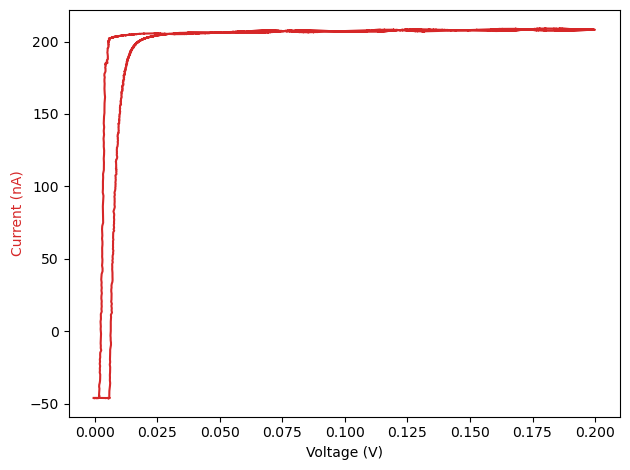

32630.160790195045 nS
W2
Thresh Current:200nA bias:4.0V


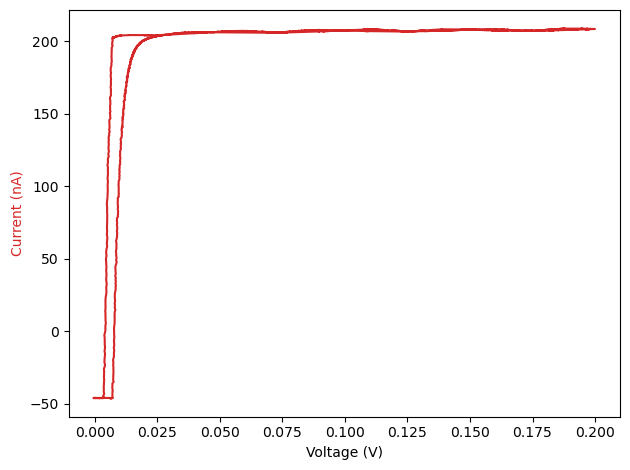

35364.20336454898 nS
W3
Thresh Current:200nA bias:4.0V


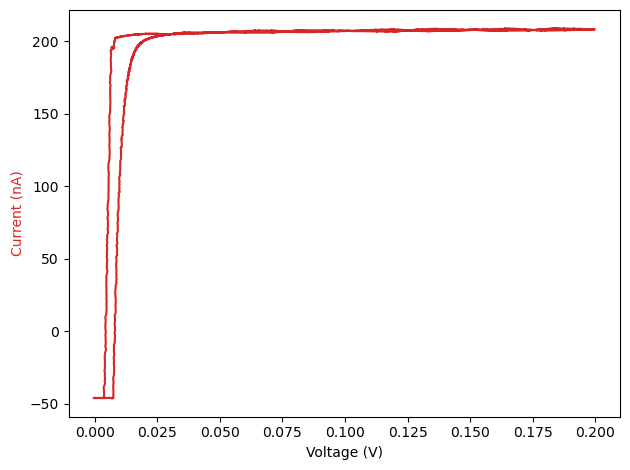

35392.38557976446 nS
W4
Thresh Current:200nA bias:4.0V


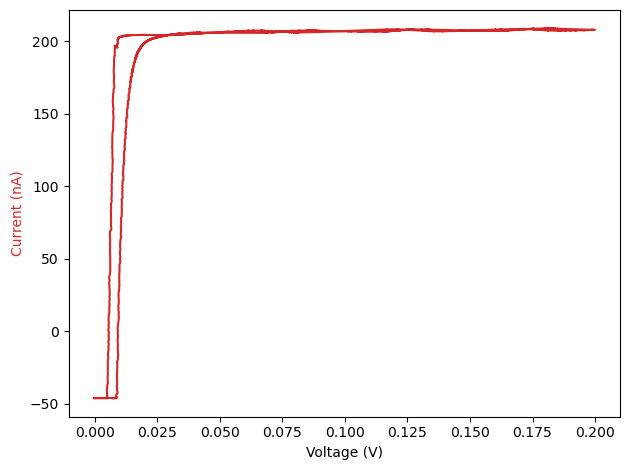

35662.98651074939 nS
W5
Thresh Current:200nA bias:4.0V


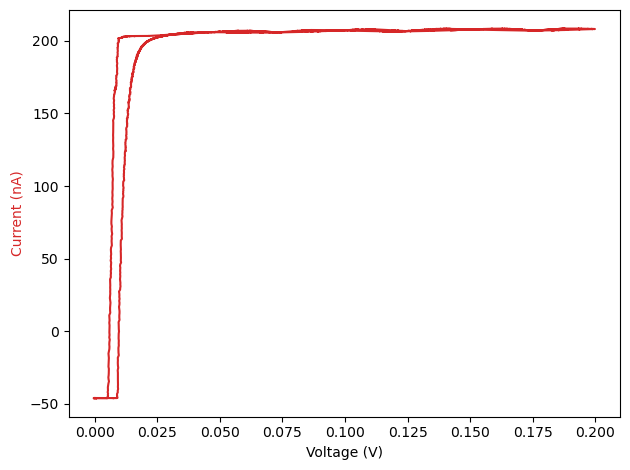

35303.20624901269 nS
W6
Thresh Current:200nA bias:4.0V


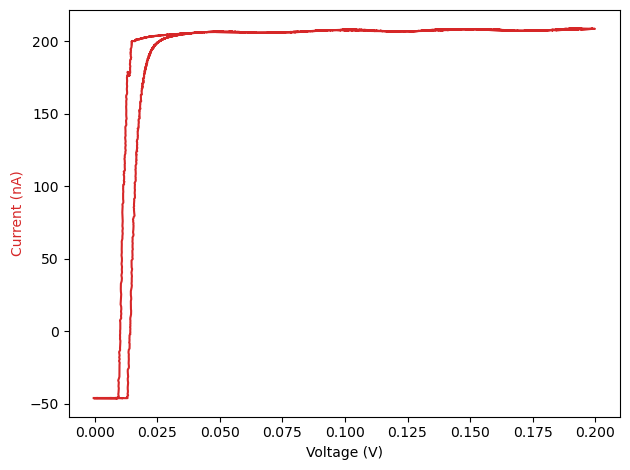

28842.068838243482 nS
W7
Thresh Current:200nA bias:4.0V


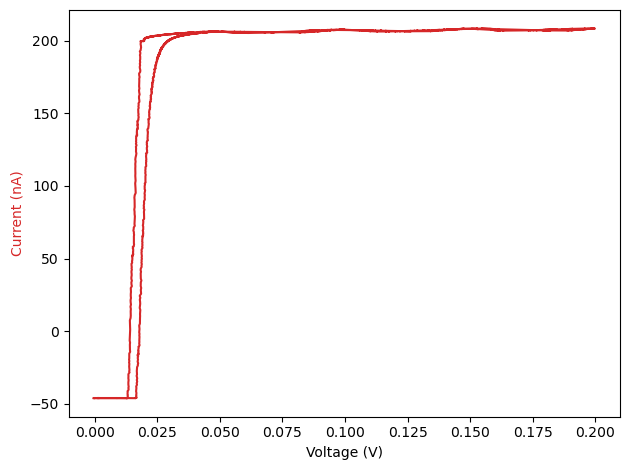

23527.822661926097 nS
W8
Thresh Current:200nA bias:4.0V


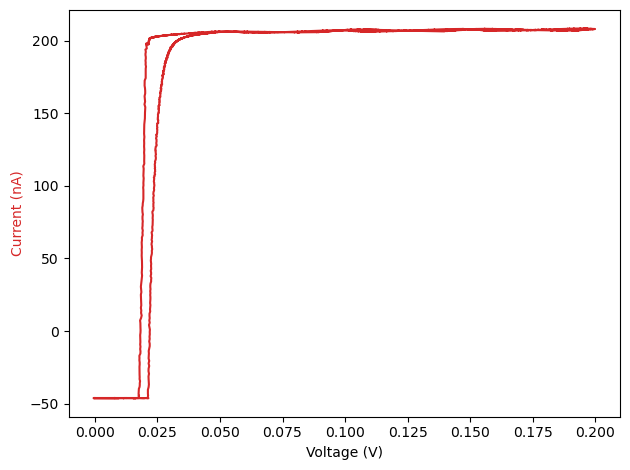

19438.5412148123 nS
N1
Thresh Current:200nA bias:4.0V


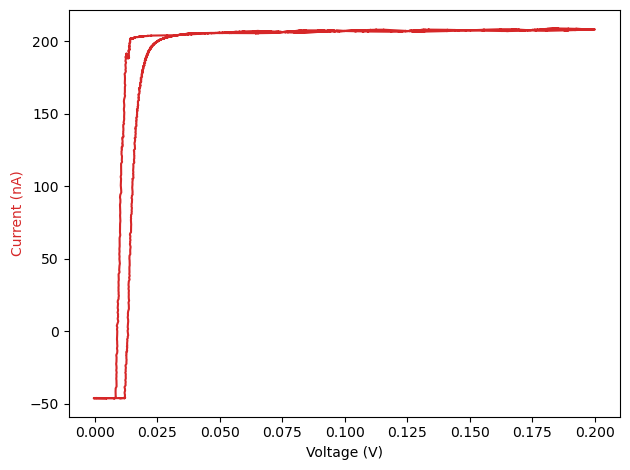

30157.127849113524 nS
N2
Thresh Current:200nA bias:4.0V


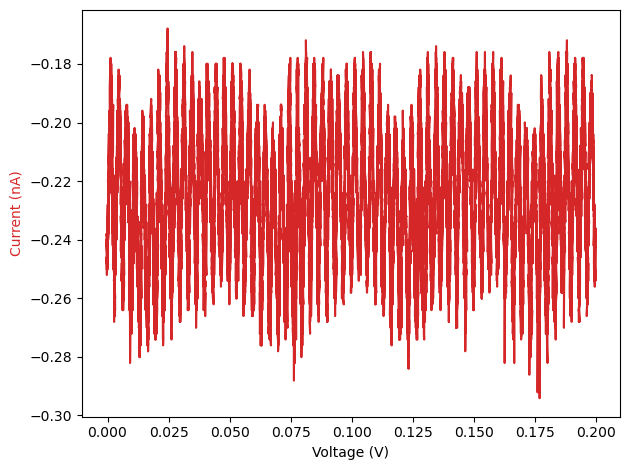

0.030605047091043804 nS
N3
Thresh Current:200nA bias:4.0V


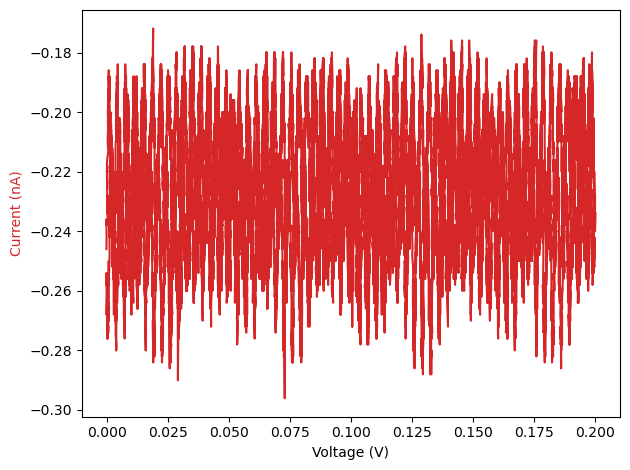

0.10211861549173237 nS
N4
Thresh Current:200nA bias:4.0V


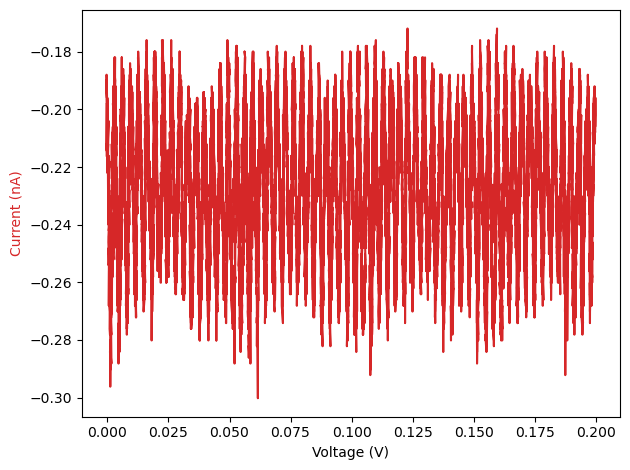

-0.08178248426379363 nS
N5
Thresh Current:200nA bias:4.0V


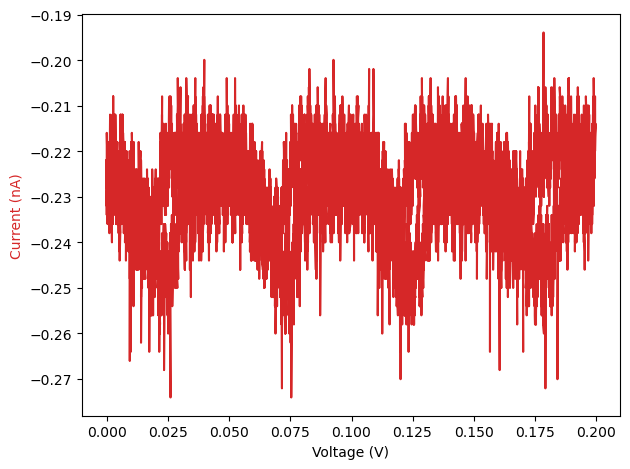

0.06199796614650224 nS
N6
Thresh Current:200nA bias:4.0V


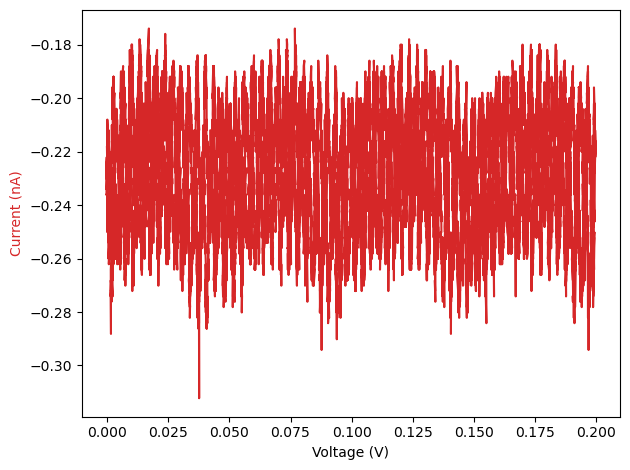

0.008641580083193282 nS
N7
Thresh Current:200nA bias:4.0V


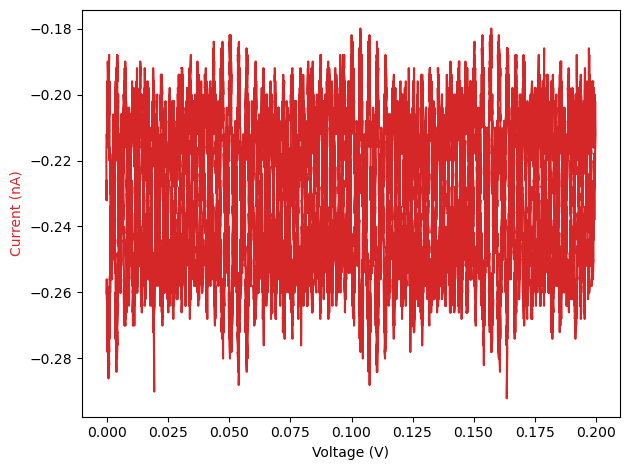

-0.07395098695601408 nS
N8
Thresh Current:200nA bias:4.0V


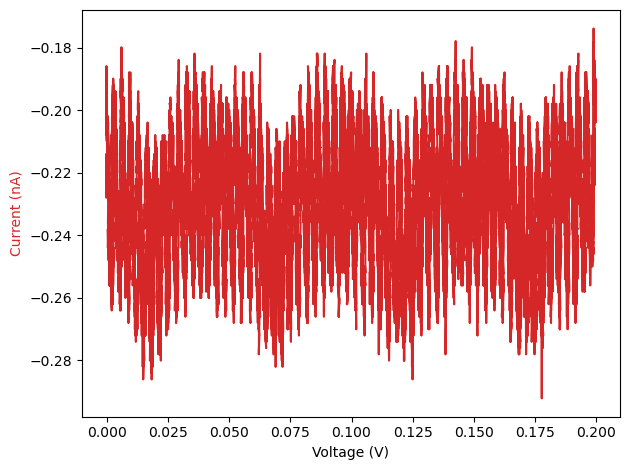

0.04885603198639308 nS
E1
Thresh Current:200nA bias:4.0V


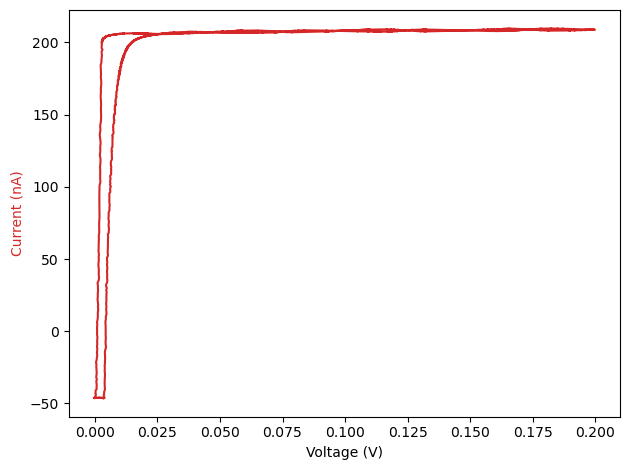

26311.011903598876 nS
E2
Thresh Current:200nA bias:4.0V


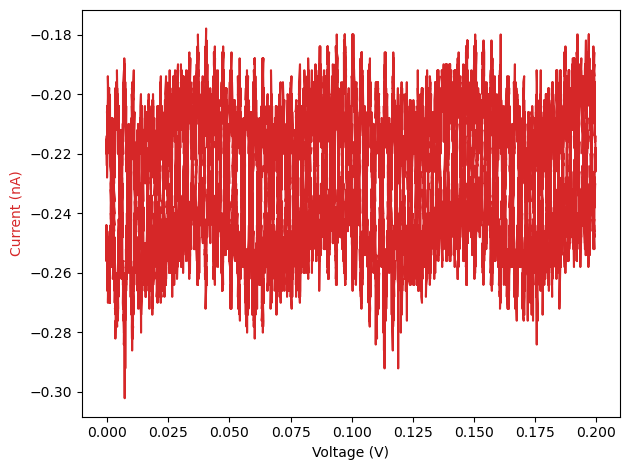

-0.012197581264094348 nS
E3
Thresh Current:200nA bias:4.0V


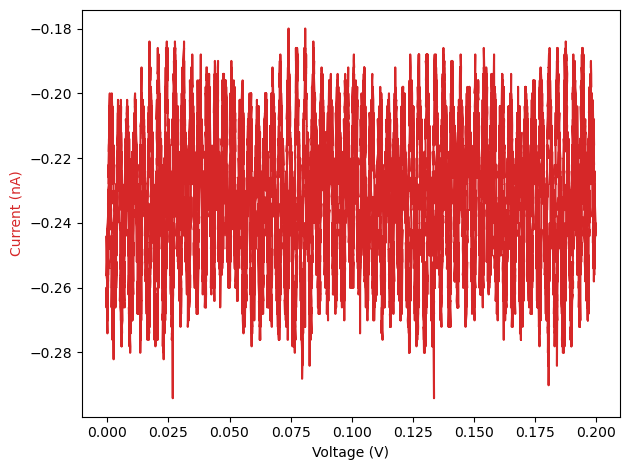

0.06677686851771782 nS
E4
Thresh Current:200nA bias:4.0V


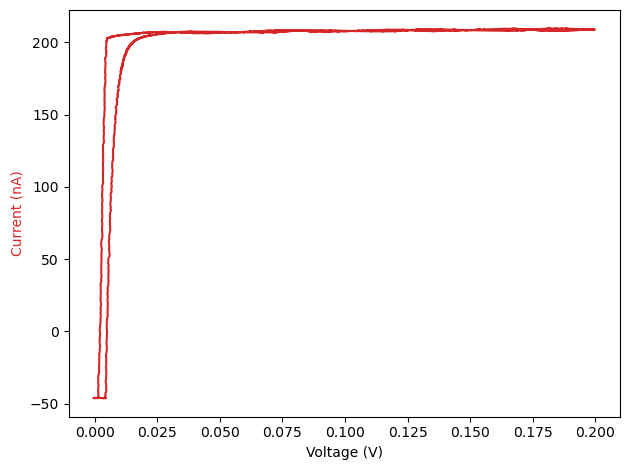

28392.82811843954 nS
E5
Thresh Current:200nA bias:4.0V


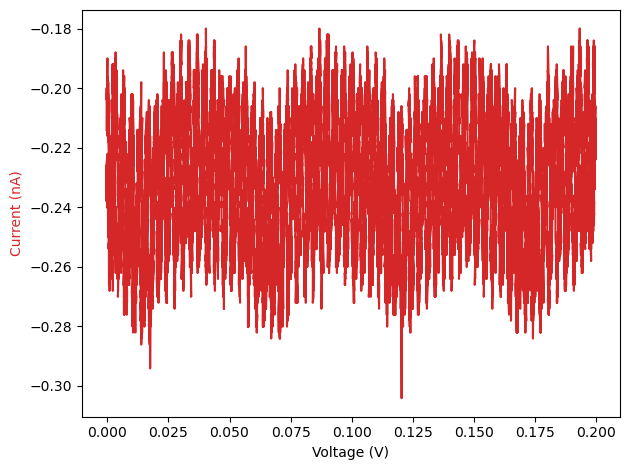

0.006266022910166793 nS
E6
Thresh Current:200nA bias:4.0V


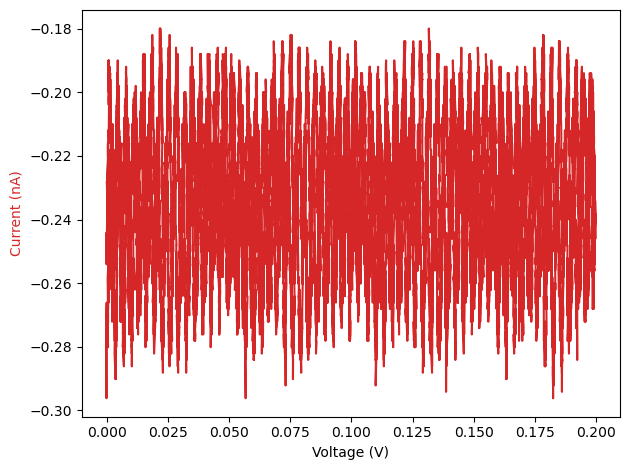

0.07958347948082165 nS
E7
Thresh Current:200nA bias:4.0V


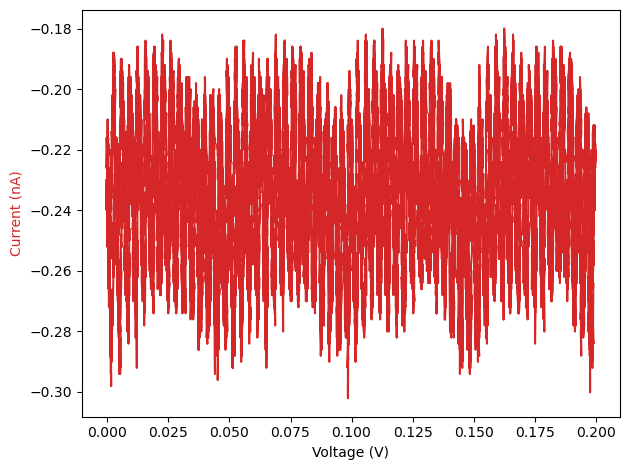

-0.05255181850375001 nS
E8
Thresh Current:200nA bias:4.0V


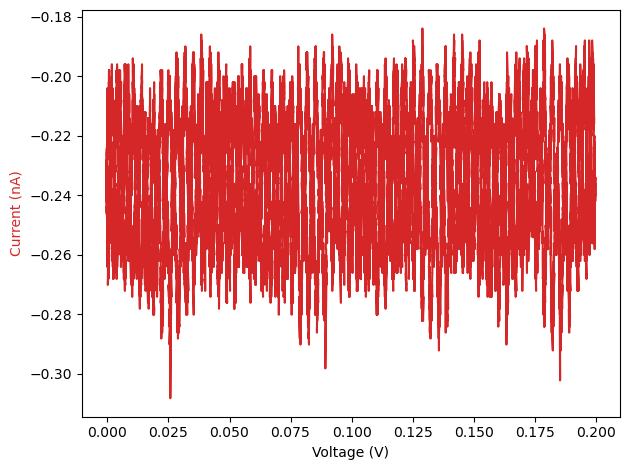

0.09043509488120934 nS
S1
Thresh Current:200nA bias:4.0V


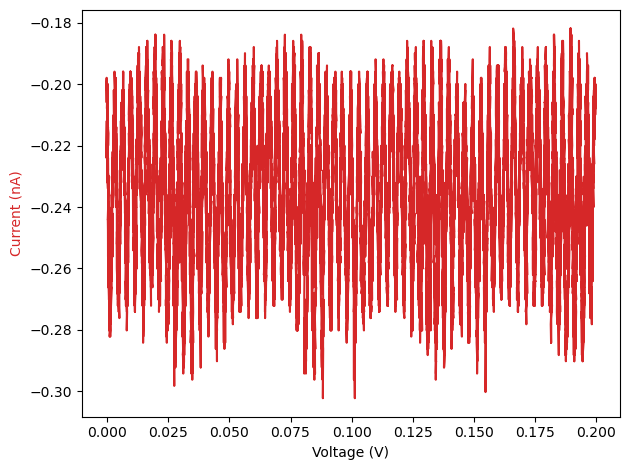

0.09842398949364728 nS
S2
Thresh Current:200nA bias:4.0V


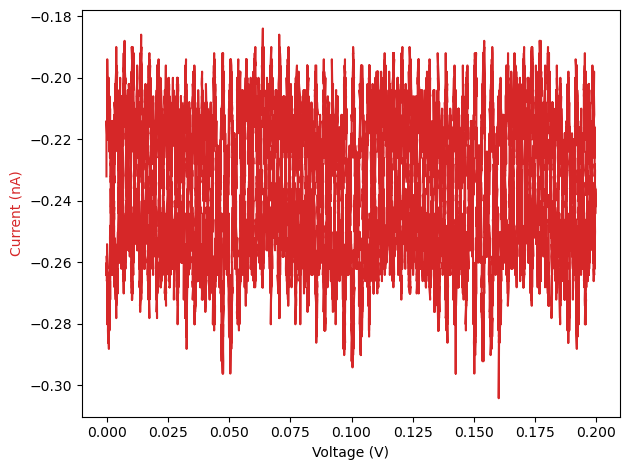

-0.09668728276282132 nS
S3
Thresh Current:200nA bias:4.0V


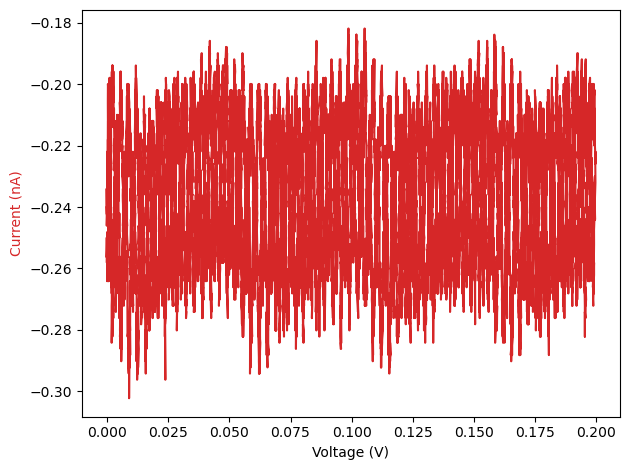

-0.012302192928555469 nS
S4
Thresh Current:200nA bias:4.0V


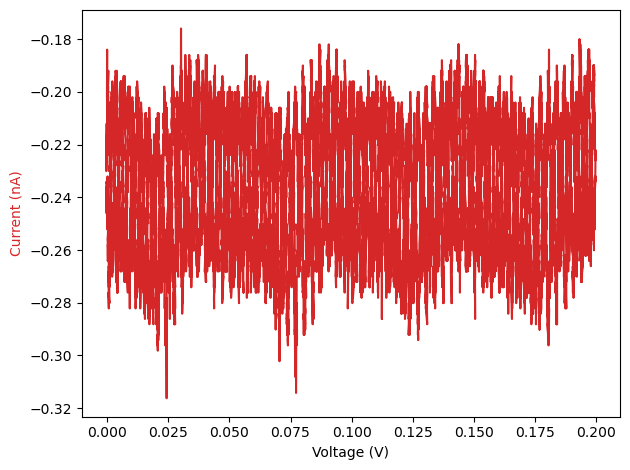

0.021977055925052537 nS
S5
Thresh Current:200nA bias:4.0V


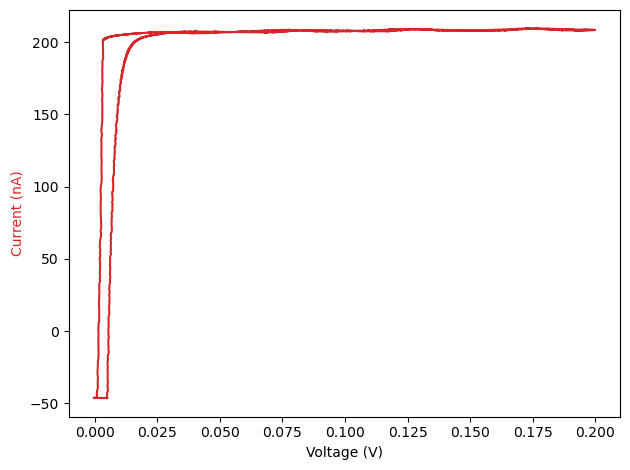

30724.32192104121 nS
S6
Thresh Current:200nA bias:4.0V


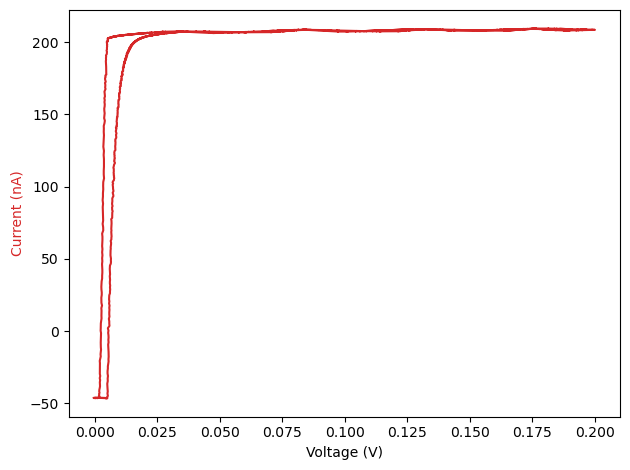

31135.964258879856 nS
S7
Thresh Current:200nA bias:4.0V


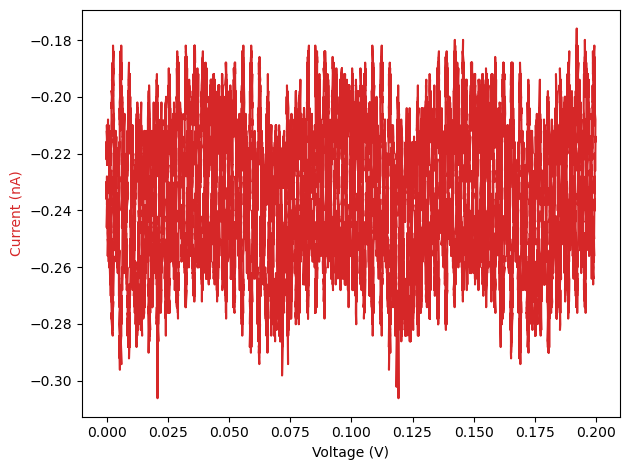

0.018911284537498498 nS
S8
Thresh Current:200nA bias:4.0V


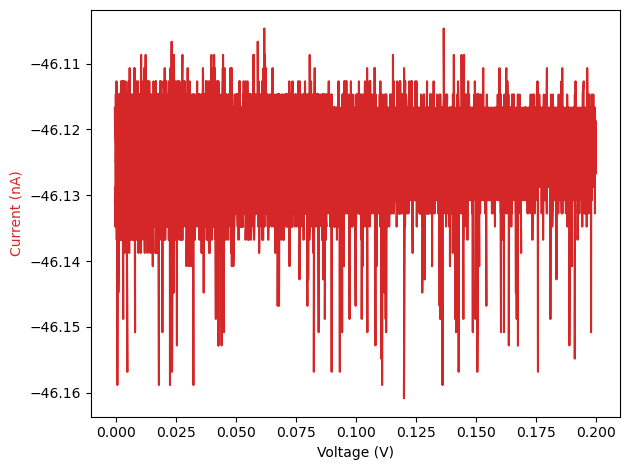

0.03667985099182376 nS


In [8]:
for channel in  plater.channels:
    plater.setBias(0)
    plater.SelectChannel(channel)
    if channel not in currentholder:
        currentholder[channel]={}
    print(channel)
    time.sleep(1)
    plater.TopElectrode()


    plater.setThreshold(current_nA = 200)
    plater.ResetDevice()
    plater.disableThreshold()
    plater.setBias(0)    

   

    conductance_nA, outBias,currents =plater.runIV2( maxVoltage_mV=200, slew_mV_s=200, plot=True)

    if "tops" not in currentholder[channel]:
        currentholder[channel]["tops"]={}
        
    with open(f'C:/Data/Plater/{wafer}/{chip}/{channel}_After_IV.np', 'wb') as fp:
        np.save(fp,outBias)
        np.save(fp,currents)
        np.save(fp,conductance_nA)
  
    currentholder[channel]["tops"]['AfterIV']={"conductance_nA":conductance_nA, "outBias":outBias,"currents":currents}

dictionary saved successfully to file


KeyError: 'strip'

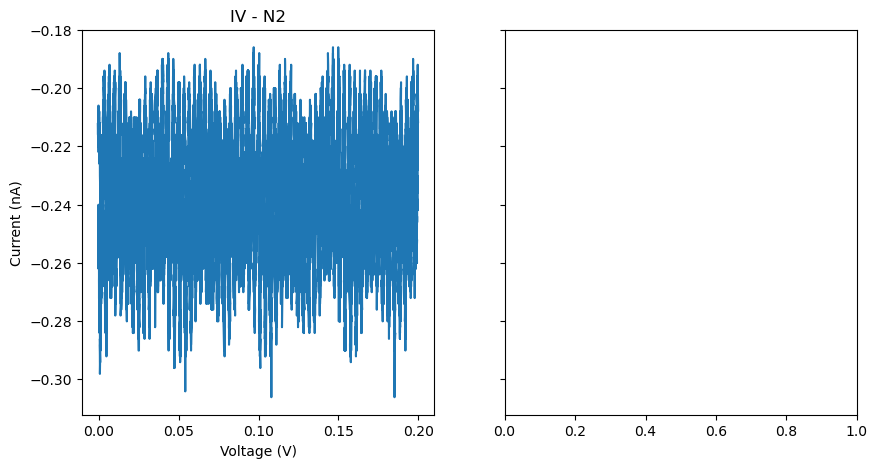

In [9]:
for channel in  plater.channels:
    ivParams = currentholder[channel]["tops"]['IVParams']
    
    bias = ivParams['outBias']
    cur=ivParams['currents']
    if np.max(cur)<180 and np.max(cur)>-40:
        
        fig,axs=plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=True, figsize=(10,5))
        axs[0].set_title(f'IV - {channel}')
        axs[0].plot(bias,cur)
        axs[0].set_xlabel('Voltage (V)')
        axs[0].set_ylabel('Current (nA)')
        
        
        strip=currentholder[channel]["strip"]
        bias = strip['biasi']
        cur = strip['currents']
        axs[1].set_title(f'Strip - {channel}')
        axs[1].plot(bias,bias)
        axs[1].set_xlabel('Voltage (V)')
        axs[1].set_ylabel('Current (nA)')
        plt.show()
        
        
        fig,axs=plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=True, figsize=(10,5))
        axs[0].set_xlabel('Voltage (V vs Ag/AgCl)')
        axs[0].set_ylabel('Current (nA)')
        
        cvparams= currentholder[channel]["tops"]['CVParams'] 
        Vs=cvparams["Vs"]
        DeviceCs=cvparams["DeviceCs"]
        axs[0].plot(Vs,DeviceCs,'r',label='Before RD')
        
        cvparams= currentholder[channel]["bottoms"]['CVParams'] 
        Vs=cvparams["Vs"]
        DeviceCs=cvparams["DeviceCs"]
        axs[1].plot(Vs,DeviceCs,'r',label='Before RD')
         
        
        cvparams= currentholder[channel]["tops2"]['CVParams'] 
        Vs=cvparams["Vs"]
        DeviceCs=cvparams["DeviceCs"]
        axs[0].plot(Vs,DeviceCs,'b',label='After RD')
        
        cvparams= currentholder[channel]["bottoms2"]['CVParams'] 
        Vs=cvparams["Vs"]
        DeviceCs=cvparams["DeviceCs"]
        axs[1].plot(Vs,DeviceCs,'b',label='After RD')
        axs[0].legend()
        axs[1].legend()
        axs[0].set_title(f'{channel} TE - Selective Desorption')
        axs[1].set_title(f'{channel} BE')
        
        plt.show()
        
        
        
        
        


In [10]:
with open('C:\Data\data.pkl', 'rb') as fp:
    currentholder2 = pickle.load(fp)

In [38]:
plater.__exit__()

{'biasi': array([-0.        ,  0.00100167,  0.00200334, ...,  0.00200334,
         0.00100167, -0.        ]),
 'currents': [-0.00849096506305043,
  -0.0009110313004545563,
  -0.000269343784078529,
  3.998961969658776],
 'rpotentials': array([-2.13623047e-05, -2.13623047e-05, -2.13623047e-05, ...,
        -2.13623047e-05, -2.13623047e-05, -2.13623047e-05]),
 'pcurrents': array([-0.00030945, -0.00050998, -0.00034955, ..., -0.00038966,
        -0.00038966, -0.00091103])}

In [7]:
myProcedure = autolab.LoadProcedure(r"C:\Data\StandardCV.nox")
myProcedure.Measure()
Vs=[]
Cs=[]

#potential = autolab.Ei.Sampler.GetSignal("WE(1).Potential")
#current =  autolab.Ei.Sampler.GetSignal("WE(1).Current")
 
    
lPot=0
lCur=0
while (myProcedure.IsMeasuring):
    pot,cur=float(autolab.Ei.get_Potential()),float(autolab.Ei.Current)
    if lPot!=pot:
        lPot,lCur=pot,cur
        Vs.append( pot )
        Cs.append( cur )
        if len(Vs)%10==0:
            clear_output()
            plt.plot(Vs,Cs)
            plt.show()
        
    
    maxVoltage_V=-1.2
startVoltage_V=0
slew_mV_s=100

slew_V_s=slew_mV_s/1000.0

samplesPerSec=200

segmentTime1 = np.abs(maxVoltage_V-startVoltage_V)/slew_V_s
segmentPoints =int( segmentTime1*samplesPerSec)
S1=np.linspace(startVoltage_V,maxVoltage_V,segmentPoints)

segmentTime2 = np.abs(maxVoltage_V-startVoltage_V)/slew_V_s
segmentPoints =int( segmentTime2*samplesPerSec)
S2=np.linspace(maxVoltage_V, startVoltage_V,segmentPoints)


biasi = np.concatenate( [S1,S2])*-1


currents =[]
pcurrents =[]
rpotentials =[]
with nidaqmx.Task(new_task_name ='iMonTask') as iMonTask, nidaqmx.Task(new_task_name ='biasTask') as biasTask, nidaqmx.Task(new_task_name ='we1Task') as weTask:
    iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai6")
    iMonTask.ai_channels.add_ai_voltage_chan("Dev1/ai7")
    iMonTask.ai_channels.add_ai_voltage_chan("Dev1/_ao0_vs_aognd")
    iMonTask.ai_channels.add_ai_voltage_chan("Dev1/_ao1_vs_aognd")
    
    biasTask.ao_channels.add_ao_voltage_chan("Dev1/ao0")
    SetRefPotential(0)
    CellOnOff(True)     
    time.sleep(5)
    for bias in biasi:
        SetRefPotential(bias)
        biasTask.write(bias, auto_start=True)
        time.sleep(1.0/samplesPerSec)
        current = iMonTask.read()
        pot,cur=float(autolab.Ei.get_Potential()),float(autolab.Ei.Current)
        pcurrents.append(current[1])
        rpotentials.append(pot)
        currents.append(current[0])

        
SetRefPotential(0)
CellOnOff(False)     
    
plt.plot(-1*biasi,currents)
plt.show()
plt.plot(-1*biasi,pcurrents )

['W1',
 'W2',
 'W3',
 'W4',
 'W5',
 'W6',
 'W7',
 'W8',
 'N1',
 'N2',
 'N3',
 'N4',
 'N5',
 'N6',
 'N7',
 'N8',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8']

In [ ]:



autolab.Disconnect()